# Install Torch

In [1]:
torchver = "0.4.0"

In [2]:
!/opt/bin/nvidia-smi || /usr/bin/nvidia-smi

/bin/sh: 1: /opt/bin/nvidia-smi: not found
Fri May 25 10:51:03 2018       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 390.25                 Driver Version: 390.25                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 980     Off  | 00000000:01:00.0  On |                  N/A |
|  6%   56C    P2    44W / 185W |    168MiB /  4038MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                 

In [3]:
!ls /colabtools

ls: cannot access '/colabtools': No such file or directory


In [4]:
!python --version

Python 3.6.5 :: Anaconda, Inc.


In [5]:
!pip3 uninstall -y pillow
!CC="cc -mavx2" pip3 install -U --force-reinstall pillow-simd


Uninstalling Pillow-5.1.0:
  Successfully uninstalled Pillow-5.1.0
tensorflow 1.3.0 requires tensorflow-tensorboard<0.2.0,>=0.1.0, which is not installed.
scikit-image 0.13.0 requires pillow>=2.1.0, which is not installed.
torchvision 0.2.0 requires pillow>=4.1.1, which is not installed.
django-haystack 2.8.1 has requirement Django>=1.11, but you'll have django 1.7.11 which is incompatible.
  Found existing installation: Pillow-SIMD 5.1.1.post0
    Uninstalling Pillow-SIMD-5.1.1.post0:
      Successfully uninstalled Pillow-SIMD-5.1.1.post0


In [6]:

!pip3 install ipdb


tensorflow 1.3.0 requires tensorflow-tensorboard<0.2.0,>=0.1.0, which is not installed.
scikit-image 0.13.0 requires pillow>=2.1.0, which is not installed.
torchvision 0.2.0 requires pillow>=4.1.1, which is not installed.
django-haystack 2.8.1 has requirement Django>=1.11, but you'll have django 1.7.11 which is incompatible.


In [7]:

from os import path
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())

pver = !python --version |& awk '{print $2 }' | awk -F. '{ print $1$2}'
pyver = pver[0]
print(pyver)

# cver = !echo "cu`nvcc --version | sed "s/ /\n/g" | grep -i release -A 1 | tail -n 1 | tr -d [\.,]`"
# cudaver = cver[0]
cudaver = 'cu91'

accelerator =  cudaver if path.exists('/opt/bin/nvidia-smi') or path.exists('/usr/bin/nvidia-smi') else 'cpu'
print(accelerator)

torchurl = "http://download.pytorch.org/whl/{0}/torch-{1}-cp{2}-cp{2}m-linux_x86_64.whl".format(accelerator, torchver, pyver)
print(torchurl)

!pip3 install http://download.pytorch.org/whl/cu91/torch-0.4.0-cp36-cp36m-linux_x86_64.whl 
!pip3 install torchvision

import torch
import torchvision
print(torchvision.get_image_backend())

36
cu91
http://download.pytorch.org/whl/cu91/torch-0.4.0-cp36-cp36m-linux_x86_64.whl
tensorflow 1.3.0 requires tensorflow-tensorboard<0.2.0,>=0.1.0, which is not installed.
scikit-image 0.13.0 requires pillow>=2.1.0, which is not installed.
torchvision 0.2.0 requires pillow>=4.1.1, which is not installed.
django-haystack 2.8.1 has requirement Django>=1.11, but you'll have django 1.7.11 which is incompatible.
  Using cached https://files.pythonhosted.org/packages/5f/4b/8b54ab9d37b93998c81b364557dff9f61972c0f650efa0ceaf470b392740/Pillow-5.1.0-cp36-cp36m-manylinux1_x86_64.whl
tensorflow 1.3.0 requires tensorflow-tensorboard<0.2.0,>=0.1.0, which is not installed.
django-haystack 2.8.1 has requirement Django>=1.11, but you'll have django 1.7.11 which is incompatible.
PIL


In [8]:
!pip3 install tqdm

tensorflow 1.3.0 requires tensorflow-tensorboard<0.2.0,>=0.1.0, which is not installed.
django-haystack 2.8.1 has requirement Django>=1.11, but you'll have django 1.7.11 which is incompatible.


# Imports

In [9]:
import torch
import os
import sys
import logging
import io
import time
import shutil
from tqdm import tqdm
from matplotlib.pyplot import imshow
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.distributed as dist
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
import torch.utils.data
import torch.utils.data.distributed
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
from argparse import Namespace

In [10]:
%matplotlib inline

# Parameters

In [11]:
args = Namespace()
# base_dir = '/content/fashion'
args.base_dir = '/data/datasets/kaggle_fashion'
args.data_dir = args.base_dir + os.sep + 'data'
args.input_dir = args.data_dir + os.sep + 'input'
args.output_dir = args.data_dir + os.sep + 'output'
args.train_zip = args.input_dir + os.sep + 'train_data.zip'
args.val_zip = args.input_dir + os.sep + 'validation_data.zip'
args.train_dir = args.input_dir + os.sep + 'train_data'
args.val_dir = args.input_dir + os.sep + 'validation_data'
args.train_id = "1rx1rL8RUAggN4hKlrYLtpdQagtUWmIbO"
args.val_id = "1U19eWiBFJ6wGcFk47l6g9mmoWp1i4hPY"
# args.train_labels_id = "1NOoWniR3ioqPKbVWoaWGy4HPDzZAAJX9"
args.train_labels_id = "1X7TpWyxxtmCT5rw__7OKus_W4fh8xpKO" # small dataset
args.val_labels_id = "1d9RuQTx5E8qFxraIu6B4rDTOC4sx2xXT"
args.test_labels_id = "1VwzGCJfOL13pk1Wi-xPHQ6mVnofy9_Z4"
# args.train_labels_json = args.input_dir + os.sep + 'train.json'
# args.train_labels_json = args.input_dir + os.sep + 'train_small.json' 
args.train_labels_json = args.input_dir + os.sep + 'train_tiny.json' 
args.val_labels_json = args.input_dir + os.sep + 'validation.json'
args.test_labels_json = args.input_dir + os.sep + 'test.json'
args.debug_weights = True
args.test_overfit = True
args.num_labels = 228
args.batch_size = 16
args.image_min_size = 256
args.nw_input_size = 224
args.num_workers = 4
args.imagenet_mean = [0.485, 0.456, 0.406]
args.imagenet_std = [0.229, 0.224, 0.225]
args.pretrain_dset_mean = args.imagenet_mean
args.pretrain_dset_std = args.imagenet_std
args.world_size = 1
args.dist_url = 'file://' + args.output_dir + os.sep + 'dfile'
args.dist_backend = 'gloo'
args.distributed = args.world_size > 1
args.arch = 'resnet101'
args.fv_size = 2048
args.pretrained = True
args.resume = False
args.start_epoch = 0
args.small=1e-12                         # small value used for avoiding div by zero
args.optimizer_learning_rate = 1e-3      # Adam optimizer initial learning rate
args.scheduler_patience = 1              # Number of epochs with no improvement after which learning rate will be reduced
args.scheduler_threshold = 1e-6          # learning rate scheduler threshold for measuring the new optimum, to only focus on significant changes
args.scheduler_factor = 0.1        # learning rate scheduler factor by which the learning rate will be reduced. new_lr = lr * factor
args.earlystopping_patience = 1          # early stopping patience is the number of epochs with no improvement after which training will be stopped
args.earlystopping_min_delta = 1e-5      # minimum change in the monitored quantity to qualify as an improvement, i.e. an absolute change of less than min_delta, will count as no improvement
args.evaluate = False
args.epochs = 100
args.print_freq = args.batch_size
args.ckpt_dir = args.output_dir + os.sep + 'ckpt'
args.ckpt = args.ckpt_dir + os.sep + 'ckpt_%s.pth.tar' % (args.arch,)

In [12]:
print(torch.backends.cudnn.version())
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))


7102
True
GeForce GTX 980


In [13]:
cudnn.benchmark = True

In [14]:
os.makedirs(args.base_dir, exist_ok=True)
os.makedirs(args.data_dir, exist_ok=True)
os.makedirs(args.input_dir, exist_ok=True)
os.makedirs(args.output_dir, exist_ok=True)
os.makedirs(args.ckpt_dir, exist_ok=True)

# Download Dataset

In [15]:
# from google.colab import auth
# auth.authenticate_user()

In [16]:
# from googleapiclient.discovery import build
# import io
# from googleapiclient.http import MediaIoBaseDownload
# import json

# def md5_hash(fname, blocksize=4096):
#     """ compute md5hash of a file """
#     import hashlib
#     hash = ''
#     if not os.path.exists(fname):
#         errmsg = "File %s does not exist" % (fname)
#         print(errmsg)
#         return ''
#     try:
#         hasher = hashlib.md5()
#         with open(fname, 'rb') as f:
#             buf = f.read(blocksize)
#             while len(buf) > 0:
#                 hasher.update(buf)
#                 buf = f.read(blocksize)
#         hash = hasher.hexdigest()
#     except:
#         print("Exception in hashing file")
#         raise
#     return hash

# def _download(drive_service, file_id, loc):
#   request = drive_service.files().get_media(fileId=file_id)
#   fh = io.FileIO(loc, mode='wb')
#   downloader = MediaIoBaseDownload(fh, request, chunksize=1024*1024)
#   prev_progress = 0
#   done = False
#   with tqdm(total=100) as pbar:
#     while done is False:
#       status, done = downloader.next_chunk()
#       if status:
#         # print("Download %d%%." % int(status.progress() * 100))
#         pbar.update(int(100 *(status.progress() - prev_progress)))
#         prev_progress = status.progress()
#   print("Download Complete!")
#   file_size = os.path.getsize(loc)
#   print("Downloaded %d bytes" % (file_size))

# def download(file_id, loc):
#   """Downloads a file to local file system."""  
#   drive_service = build('drive', 'v3')
  
#   request_mdata = drive_service.files().list(fields="files(md5Checksum, originalFilename, id)")
#   rh = io.BytesIO()
#   downloader_mdata = MediaIoBaseDownload(rh, request_mdata, chunksize=1024*1024)
#   done = False
#   while not done:
#     _, done = downloader_mdata.next_chunk()
#   mdata = json.loads(rh.getvalue())
#   found = False
#   md5drive = ''
#   fname = ''
#   for x in mdata['files']:
#     if x['id'] == file_id:
#       found = True
#       md5drive = x['md5Checksum']
#       fname = x['originalFilename']
#       break
#   if not found:
#     print("{:s} : not found on gdrive".format(file_id))
#   else:
#     if os.path.exists(loc):
#       if md5drive == md5_hash(loc):
#         print("{:s} : file already present on colab".format(loc))
#       else:
#         print("{:s} [gdrive] and {:s} [colab] : md5 mismatch ... downloading".format(fname, loc))
#         _download(drive_service, file_id, loc)
#     else:
#       print("{:s} not present on colab ... downloading ...".format(loc))
#       _download(drive_service, file_id, loc)
        


In [17]:
# download(args.train_id, args.train_zip)
# download(args.val_id, args.val_zip)
# download(args.train_labels_id, args.train_labels_json)
# download(args.val_labels_id, args.val_labels_json)
# download(args.test_labels_id, args.test_labels_json)

In [18]:
# import shutil
# shutil.unpack_archive(args.train_zip, args.input_dir)
# shutil.unpack_archive(args.val_zip, args.input_dir)


In [19]:
# !ls -ltr /content/fashion/data/input

In [20]:
# !ls -ltr /content/fashion/data/input/train_data | head

In [21]:
# !ls -ltr /content/fashion/data/input/validation_data | head

# Dataset

In [22]:
import torch.utils.data as data
from copy import copy
import numpy as np

def fetch_labels(annotations, num_labels):
  labels = {}
  for x in annotations:
    arr = np.zeros((num_labels,), dtype=np.float32)
    for y in map(int, x['labelId']):
      arr[y-1] = 1.0
    # 0-indexed
    labels[int(x['imageId'])-1] = copy(arr)
  return labels

def json_to_dict(fpath):
  import json
  with open(fpath) as f: 
    D = json.load(f)
  return D

def get_labelinfo(annotations):
  from collections import namedtuple
  labelinfo = namedtuple('labelinfo', "set min max count")
  labelinfo.set = set()
  for x in annotations:
    labelinfo.set.update(map(int, x['labelId']))
  labelinfo.min = min(labelinfo.set)
  labelinfo.max = max(labelinfo.set)
  labelinfo.count = len(labelinfo.set)
  return labelinfo

def has_file_allowed_extension(filename, extensions):
    """Checks if a file is an allowed extension.
    Args:
        filename (string): path to a file
    Returns:
        bool: True if the filename ends with a known image extension
    """
    filename_lower = filename.lower()
    return any(filename_lower.endswith(ext) for ext in extensions)


def pil_loader(path):
    from PIL import Image 
    # open path as file to avoid ResourceWarning (https://github.com/python-pillow/Pillow/issues/835)
    with open(path, 'rb') as f:
        img = Image.open(f)
        return img.convert('RGB')


def accimage_loader(path):
    import accimage
    try:
        return accimage.Image(path)
    except IOError:
        # Potentially a decoding problem, fall back to PIL.Image
        return pil_loader(path)


def default_loader(path):
    from torchvision import get_image_backend
    if get_image_backend() == 'accimage':
        return accimage_loader(path)
    else:
        return pil_loader(path)

      
class FashionDataset(data.Dataset):
  """Fashion dataset CVPR challenge.
     Adapted from torchvision ImageFolder.
     Similar to ImageFolder with the following differences:
     1. Multilabel
     2. Directory structure where all images are directly in the root folder
     3. Labels are read from json file
   
  Args:
        root (string): Root directory path.
        loader (callable): A function to load a sample given its path.
        extensions (list[string]): A list of allowed extensions.
        transform (callable, optional): A function/transform that takes in
            a sample and returns a transformed version.
            E.g, ``transforms.RandomCrop`` for images.
        target_transform (callable, optional): A function/transform that takes
            in the target and transforms it.
    
  """

  def __init__(self, root, metadata_file, num_labels=228, transform=None, target_transform=None,
               loader=default_loader):
    extensions = ['.jpg', '.jpeg', '.png', '.ppm', '.bmp', '.pgm', '.tif']
    self.num_labels = num_labels
    self.images = {}
    self.metadata_file = metadata_file
    self.metadata = json_to_dict(self.metadata_file)
    self.transform = transform
    self.root = root
    self.target_transform = target_transform
    self.loader = loader
    self.labelinfo = get_labelinfo(self.metadata['annotations'])
    self.labels = fetch_labels(self.metadata['annotations'], self.num_labels)

    for x in self.metadata['images']:
      # 0-indexed
      self.images[int(x['imageId'])-1] = '%s%s%d.jpg' % (root, os.sep, int(x['imageId']))  
    

  def __getitem__(self, index):
        """
        Args:
            index (int): Index
        Returns:
            tuple: (sample, target) where target is class_index of the target class.
        """
        path, target = self.images[index], self.labels[index]
        sample = self.loader(path)
        if self.transform is not None:
            sample = self.transform(sample)
        if self.target_transform is not None:
            target = self.target_transform(target)

        return sample, target

  def __len__(self):
    return len(self.images)
  
  def __repr__(self):
    fmt_str = 'Dataset ' + self.__class__.__name__ + '\n'
    fmt_str += '    Number of datapoints: {}\n'.format(self.__len__())
    fmt_str += '    Number of labels: {}\n'.format(self.labelinfo.count)
    fmt_str += '    Root Location: {}\n'.format(self.root)
    fmt_str += '    Metadata file: {}\n'.format(self.metadata_file)
    tmp = '    Transforms (if any): '
    fmt_str += '{0}{1}\n'.format(tmp, self.transform.__repr__().replace('\n', '\n' + ' ' * len(tmp)))
    tmp = '    Target Transforms (if any): '
    fmt_str += '{0}{1}'.format(tmp, self.target_transform.__repr__().replace('\n', '\n' + ' ' * len(tmp)))
    tmp = '    Loader: '
    fmt_str += '\n{0}{1}'.format(tmp, self.loader.__name__)
    return fmt_str

  

In [23]:
import torchvision.transforms as transforms

def create_transforms(args):
    if args.test_overfit:
        train_tform = transforms.Compose([transforms.Resize(args.image_min_size),
                                          transforms.CenterCrop(args.nw_input_size),
                                          transforms.ToTensor(),
                                          transforms.Normalize(mean=args.pretrain_dset_mean,
                                                                std=args.pretrain_dset_std)
                                         ])
    else:
        train_tform = transforms.Compose([transforms.RandomResizedCrop(args.nw_input_size),
                                          transforms.RandomHorizontalFlip(),
                                          transforms.ToTensor(),
                                          transforms.Normalize(mean=args.pretrain_dset_mean,
                                                                std=args.pretrain_dset_std)
                                         ])

    val_tform = transforms.Compose([transforms.Resize(args.image_min_size),
                                    transforms.CenterCrop(args.nw_input_size),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=args.pretrain_dset_mean,
                                                         std=args.pretrain_dset_std)
                                   ])
    return (train_tform, val_tform)

In [24]:
train_tform, val_tform = create_transforms(args)

In [25]:
train_dset = FashionDataset(args.train_dir, args.train_labels_json, args.num_labels, transform=train_tform)
val_dset = FashionDataset(args.val_dir, args.val_labels_json, args.num_labels, transform=val_tform)


print(train_dset)
print(val_dset)

Dataset FashionDataset
    Number of datapoints: 128
    Number of labels: 122
    Root Location: /data/datasets/kaggle_fashion/data/input/train_data
    Metadata file: /data/datasets/kaggle_fashion/data/input/train_tiny.json
    Transforms (if any): <torchvision.transforms.transforms.Compose object at 0x7fdbbf708be0>
    Target Transforms (if any): None
    Loader: default_loader
Dataset FashionDataset
    Number of datapoints: 9897
    Number of labels: 225
    Root Location: /data/datasets/kaggle_fashion/data/input/validation_data
    Metadata file: /data/datasets/kaggle_fashion/data/input/validation.json
    Transforms (if any): <torchvision.transforms.transforms.Compose object at 0x7fdbbf708438>
    Target Transforms (if any): None
    Loader: default_loader


In [26]:
def tensor_to_numpy(t, avg, std):
  return (255.0 * (np.transpose(np.asarray(t), (1, 2, 0)) * std + avg)).astype(np.uint8)
  

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.
 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


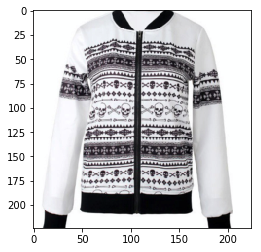

In [27]:
rnd1 = np.random.randint(len(train_dset))
im1, lbl1 = train_dset[rnd1]
imshow(tensor_to_numpy(im1, args.pretrain_dset_mean, args.pretrain_dset_std))
print(lbl1)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


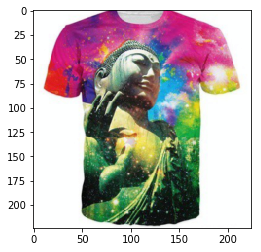

In [28]:
rnd2 = np.random.randint(len(val_dset))
im2, lbl2 = val_dset[rnd2]
imshow(tensor_to_numpy(im2, args.pretrain_dset_mean, args.pretrain_dset_std))
print(lbl2)

# DataLoader

In [29]:
if args.distributed:
    dist.init_process_group(backend=args.dist_backend,
                            init_method=args.dist_url,
                            world_size=args.world_size)


In [30]:
from torch.utils.data.distributed import DistributedSampler 


if args.distributed:
  train_sampler = DistributedSampler(train_dset)
else:
  train_sampler = None

train_loader = torch.utils.data.DataLoader(train_dset,
                                           batch_size=args.batch_size,
                                           shuffle=(train_sampler is None),
                                           num_workers=args.num_workers,
                                           pin_memory=True,
                                           sampler=train_sampler
                                          )

val_loader = torch.utils.data.DataLoader(val_dset,
                                         batch_size=args.batch_size,
                                         shuffle=False,
                                         num_workers=args.num_workers,
                                         pin_memory=True
                                        )


In [31]:
# train_images, train_labels = next(iter(train_loader))

In [32]:
# rnd11 = np.random.randint(args.batch_size)
# print(train_images[rnd11,:,:,:])
# print(train_labels[rnd11, :])

In [33]:
# val_images, val_labels = next(iter(val_loader))

In [34]:
# rnd21 = np.random.randint(args.batch_size)
# print(val_images[rnd21,:,:,:])
# print(val_labels[rnd21, :])


# Model

In [35]:
import torch.nn.init as weight_init


class FCWithLogSigmoid(nn.Module):
  
  def __init__(self, num_inputs, num_outputs):
    super(FCWithLogSigmoid, self).__init__()
    self.linear = nn.Linear(num_inputs, num_outputs)
    self.logsigmoid = nn.LogSigmoid()
    
  def forward(self, x):
    return self.logsigmoid(self.linear(x))


def create_model(arch, num_labels=228, fv_size=2048, pretrained=True, resume=False, distributed=False):
  if pretrained:
      print("=> using pre-trained model '{}'".format(arch))
      model = models.__dict__[arch](pretrained=True)
  else:
      print("=> creating model '{}'".format(arch))
      model = models.__dict__[arch]()
  model.fc = FCWithLogSigmoid(fv_size, num_labels)
  if not distributed:
      if arch.startswith('alexnet') or arch.startswith('vgg'):
          model.features = torch.nn.DataParallel(model.features)
          model.cuda()
      else:
          model = torch.nn.DataParallel(model).cuda()
  else:
      model.cuda()
      model = torch.nn.parallel.DistributedDataParallel(model)
  return model


In [36]:
def count_parameters(model):
  """source: https://discuss.pytorch.org/t/how-do-i-check-the-number-of-parameters-of-a-model/4325/9"""
  return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [37]:
model = create_model(args.arch,
                     num_labels=args.num_labels,
                     fv_size=args.fv_size,
                     pretrained=args.pretrained,
                     resume=args.resume,
                     distributed=args.distributed)

=> using pre-trained model 'resnet101'


In [38]:
print("Neural Network has ", count_parameters(model), " trainable parameters")

Neural Network has  42967332  trainable parameters


In [39]:
class WeightUpdateTracker:
    
    def __init__(self, model):
        with torch.no_grad():
            self.num_param_tensors = len(list(model.parameters()))
            self.prev_pnorms = torch.zeros(self.num_param_tensors) 
            self.curr_pnorms = self.parameter_norms(model) 

    def parameter_norms(self, model):
        with torch.no_grad():
            pnorms = torch.zeros(self.num_param_tensors)
            for i, x in enumerate(list(model.parameters())):
                pnorms[i] = x.norm().item()
            return pnorms
        
    def track(self, model):
        with torch.no_grad():
            self.prev_pnorms = self.curr_pnorms.clone()
            self.curr_pnorms = self.parameter_norms(model)
            self.delta = (self.curr_pnorms - self.prev_pnorms) / self.prev_pnorms

            
    def __repr__(self):
        with torch.no_grad():
            return self.delta.__repr__()
        

# Loss Function


In [40]:
criterion = torch.nn.BCEWithLogitsLoss().cuda()

# Update Rule

In [41]:
optimizer = optim.Adam(model.parameters(),
                       amsgrad=True,
                       lr=args.optimizer_learning_rate,
                       betas=(0.9, 0.999),
                       eps=1e-8,
                       weight_decay=0.0
                      )
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer,
                                           mode='max',   # F1 measure
                                           patience=args.scheduler_patience,
                                           threshold=args.scheduler_threshold,
                                           factor=args.scheduler_factor,
                                           verbose=1
                                          )


# Training Loop


In [42]:
def load_checkpoint(model, optimizer, scheduler, args, resume=True, ckpt=None):
    """optionally resume from a checkpoint."""
    best_f1 = 0
    if args.resume:
        if os.path.isfile(ckpt):
            print("=> loading checkpoint '{}'".format(ckpt))
            checkpoint = torch.load(ckpt)
            args.start_epoch = checkpoint['epoch']
            best_f1 = checkpoint['best_f1']
            model.load_state_dict(checkpoint['state_dict'])
            optimizer.load_state_dict(checkpoint['optimizer'])
          #  scheduler.load_state_dict(checkpoint['scheduler'])
            print("=> loaded checkpoint '{}' (epoch {})"
                  .format(args.resume, checkpoint['epoch']))
        else:
            print("=> no checkpoint found at '{}'".format(ckpt))
            best_f1 = 0
    return (model, optimizer, scheduler, args, best_f1)

In [43]:
def save_checkpoint(state, is_best, filename='checkpoint.pth.tar'):
    torch.save(state, filename)
    if is_best:
        shutil.copyfile(filename, 'model_best.pth.tar')

In [44]:
class F1MicroAverageMeter(object):
    """Computes and stores F1 store"""
    def __init__(self, threshold=0.5, small=1e-12):
        self.threshold = threshold
        self.small = small
        self.reset()

    def reset(self):
        self.TP = 0.0
        self.FP = 0.0
        self.FN = 0.0
        self.TN = 0.0
        self.precision = 0.0
        self.recall = 0.0
        self.f1 = 0.0

    def update(self, labels, pred):
        tp, fp, fn, tn = self.confusion_matrix_(labels, pred)
        self.TP += tp
        self.FP += fp
        self.FN += fn
        self.TN += tn
        self.precision = self.TP / (self.small + self.TP + self.FP)
        self.recall = self.TP / (self.small + self.TP + self.FN)
        self.f1 = (2.0 * self.precision * self.recall) / (self.small + self.precision + self.recall)
        
    def confusion_matrix_(self, labels, pred):
        with torch.no_grad():
            real = labels
            fake = 1.0 - real
            pos = pred.ge(self.threshold).float()
            neg = 1.0 - pos
            tp = torch.sum(real * pos).item()
            fp = torch.sum(fake * pos).item()
            fn = torch.sum(real * neg).item()
            tn = torch.sum(fake * neg).item()
            return (tp, fp, fn, tn)
              

In [45]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [46]:
def adjust_learning_rate(optimizer, scheduler, epoch, measure, args):
    if not args.test_overfit:
        scheduler.step(measure)


In [47]:
def train(train_loader, model, criterion, optimizer, epoch):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    cmpoint5 = F1MicroAverageMeter(threshold=0.5)

    # switch to train mode
    model.train()

    end = time.time()
    for i, (input, target) in enumerate(train_loader):
        # measure data loading time
        data_time.update(time.time() - end)

        target = target.cuda(non_blocking=True)

        # compute output
        output = model(input)
        loss = criterion(output, target)

        # measure F1 and record loss
        losses.update(loss.item(), input.size(0))
        cmpoint5.update(target, torch.exp(output))

        # compute gradient and do SGD step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
        
        

        if i % args.print_freq == 0:
            print('Epoch: [{0}][{1}/{2}]\t'
                  'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                  'Data {data_time.val:.3f} ({data_time.avg:.3f})\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                  'Precision {cmpoint5.precision:.3f}\t'
                  'Recall {cmpoint5.recall:.3f}\t'
                  'F1 {cmpoint5.f1:.3f}'.format(
                   epoch, i, len(train_loader), batch_time=batch_time,
                   data_time=data_time, loss=losses, cmpoint5=cmpoint5))

In [48]:
def validate(val_loader, model, criterion):
    batch_time = AverageMeter()
    losses = AverageMeter()
    cmpoint5 = F1MicroAverageMeter(threshold=0.5)

    # switch to evaluate mode
    model.eval()

    with torch.no_grad():
        end = time.time()
        for i, (input, target) in enumerate(val_loader):
            target = target.cuda(non_blocking=True)

            # compute output
            output = model(input)
            loss = criterion(output, target)

            # measure F1 and record loss
            losses.update(loss.item(), input.size(0))
            cmpoint5.update(target, torch.exp(output))
            
            # measure elapsed time
            batch_time.update(time.time() - end)
            end = time.time()

            if i % args.print_freq == 0:
                 print('Test: [{0}/{1}]\t'
                      'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                      'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                      'Precision {cmpoint5.precision:.3f}\t'
                      'Recall {cmpoint5.recall:.3f}\t'
                      'F1 {cmpoint5.f1:.3f}'.format(
                       i, len(val_loader), batch_time=batch_time, loss=losses,
                       cmpoint5=cmpoint5))

        print(' * Precision {cmpoint5.precision:.3f} Recall {cmpoint5.recall:.3f} F1 {cmpoint5.f1:.3f}'
              .format(cmpoint5=cmpoint5))

    return cmpoint5.f1

In [ ]:
if args.evaluate:
    validate(val_loader, model, criterion)
else:
    model, optimizer, scheduler, args, best_f1 = load_checkpoint(model, optimizer, scheduler, args, resume=args.resume, ckpt=args.ckpt)
    wut = WeightUpdateTracker(model)
    for epoch in range(args.start_epoch, args.epochs):
        if args.distributed:
            train_sampler.set_epoch(epoch)
#         adjust_learning_rate(optimizer, epoch)

        # train for one epoch
        train(train_loader, model, criterion, optimizer, epoch)
        
        # debug: track weight updates
        wut.track(model)
        print(wut)
        
        # evaluate on validation set
        f1 = validate(val_loader, model, criterion)

        # remember best f1 and save checkpoint
        is_best = f1 > best_f1
        best_f1 = max(f1, best_f1)
        save_checkpoint({
            'epoch': epoch + 1,
            'arch': args.arch,
            'state_dict': model.state_dict(),
            'best_f1': best_f1,
            'optimizer' : optimizer.state_dict(),
           # 'scheduler' : scheduler.state_dict(),
        }, is_best, filename=args.ckpt)
        
        adjust_learning_rate(optimizer, scheduler, epoch, f1, args)
        


Epoch: [0][0/8]	Time 4.452 (4.452)	Data 1.030 (1.030)	Loss 0.4207 (0.4207)	Precision 0.028	Recall 0.556	F1 0.053
tensor([ 4.5522e-04, -3.7199e-04,  7.3327e-05,  5.0581e-04,  6.3060e-04,
        -7.7109e-04,  6.1048e-03,  1.8777e-03, -2.9205e-04,  5.1074e-03,
        -9.3644e-04,  7.5459e-03,  6.6325e-04, -8.1037e-04,  7.5459e-03,
         9.8960e-03,  1.1289e-03, -6.5937e-04,  8.0007e-03,  3.2848e-03,
        -5.2793e-03,  1.0845e-02, -6.9542e-04,  4.4783e-03,  6.8473e-03,
        -1.3028e-03,  1.0443e-02,  7.1963e-03,  1.3461e-03, -2.9918e-03,
         9.8294e-03,  2.0572e-03, -1.7403e-03,  6.5283e-03,  2.1517e-04,
         9.4734e-05,  1.2706e-02, -5.6246e-05,  4.7128e-03,  5.9421e-03,
        -6.7049e-04,  7.1734e-03,  1.0714e-02,  3.5302e-04,  7.1734e-03,
         2.5437e-02, -5.7849e-03,  2.2351e-03,  2.2756e-02, -1.9300e-03,
         5.1195e-03,  1.5011e-02,  3.0313e-03,  3.4012e-03,  1.2098e-02,
        -5.1928e-04,  5.3447e-03,  1.4751e-02,  5.7605e-05,  1.9870e-03,
         1.

Test: [608/619]	Time 0.098 (0.136)	Loss 0.1643 (0.1517)	Precision 0.355	Recall 0.219	F1 0.271
 * Precision 0.355 Recall 0.219 F1 0.271
Epoch: [1][0/8]	Time 1.691 (1.691)	Data 1.351 (1.351)	Loss 0.0784 (0.0784)	Precision 0.466	Recall 0.318	F1 0.378
tensor([ 0.0002, -0.0011,  0.0010,  0.0000, -0.0003,  0.0017,  0.0065,
        -0.0004,  0.0022,  0.0054, -0.0009,  0.0061,  0.0014, -0.0001,
         0.0061,  0.0102, -0.0033,  0.0021,  0.0086, -0.0016,  0.0016,
         0.0115,  0.0009,  0.0097,  0.0067, -0.0013,  0.0055,  0.0073,
        -0.0008,  0.0033,  0.0100, -0.0021,  0.0012,  0.0075, -0.0003,
         0.0026,  0.0129,  0.0001,  0.0025,  0.0062, -0.0002,  0.0065,
         0.0110,  0.0017,  0.0065,  0.0265, -0.0047,  0.0044,  0.0242,
        -0.0007,  0.0016,  0.0172, -0.0008,  0.0031,  0.0125, -0.0009,
         0.0053,  0.0157,  0.0001,  0.0001,  0.0120, -0.0023,  0.0020,
         0.0106, -0.0006,  0.0066,  0.0123, -0.0011,  0.0061,  0.0104,
        -0.0020,  0.0032,  0.0067, -0.0005

Test: [0/619]	Time 1.219 (1.219)	Loss 0.6855 (0.6855)	Precision 0.300	Recall 0.316	F1 0.308
Test: [16/619]	Time 0.382 (0.233)	Loss 0.8036 (0.8607)	Precision 0.239	Recall 0.267	F1 0.252
Test: [32/619]	Time 0.321 (0.194)	Loss 0.6513 (0.8537)	Precision 0.238	Recall 0.271	F1 0.253
Test: [48/619]	Time 0.264 (0.183)	Loss 0.7397 (0.9009)	Precision 0.239	Recall 0.268	F1 0.252
Test: [64/619]	Time 0.098 (0.175)	Loss 0.5365 (0.8716)	Precision 0.240	Recall 0.268	F1 0.253
Test: [80/619]	Time 0.122 (0.165)	Loss 0.8026 (0.8633)	Precision 0.242	Recall 0.269	F1 0.255
Test: [96/619]	Time 0.104 (0.162)	Loss 1.2896 (0.8490)	Precision 0.240	Recall 0.267	F1 0.253
Test: [112/619]	Time 0.098 (0.157)	Loss 0.8204 (0.8412)	Precision 0.242	Recall 0.268	F1 0.254
Test: [128/619]	Time 0.098 (0.153)	Loss 0.8794 (0.8352)	Precision 0.242	Recall 0.270	F1 0.255
Test: [144/619]	Time 0.098 (0.150)	Loss 0.9713 (0.8452)	Precision 0.242	Recall 0.269	F1 0.255
Test: [160/619]	Time 0.098 (0.148)	Loss 0.5213 (0.8472)	Precision 0.

Test: [208/619]	Time 0.324 (0.217)	Loss 0.2800 (0.1915)	Precision 0.338	Recall 0.200	F1 0.251
Test: [224/619]	Time 0.294 (0.213)	Loss 0.1930 (0.1909)	Precision 0.338	Recall 0.199	F1 0.251
Test: [240/619]	Time 0.366 (0.208)	Loss 0.1806 (0.1902)	Precision 0.339	Recall 0.200	F1 0.251
Test: [256/619]	Time 0.160 (0.204)	Loss 0.2612 (0.1902)	Precision 0.340	Recall 0.200	F1 0.252
Test: [272/619]	Time 0.231 (0.200)	Loss 0.2602 (0.1913)	Precision 0.339	Recall 0.199	F1 0.251
Test: [288/619]	Time 0.212 (0.196)	Loss 0.1865 (0.1914)	Precision 0.339	Recall 0.199	F1 0.250
Test: [304/619]	Time 0.297 (0.193)	Loss 0.2059 (0.1932)	Precision 0.337	Recall 0.198	F1 0.249
Test: [320/619]	Time 0.340 (0.193)	Loss 0.2018 (0.1935)	Precision 0.337	Recall 0.197	F1 0.249
Test: [336/619]	Time 0.487 (0.193)	Loss 0.2383 (0.1947)	Precision 0.336	Recall 0.196	F1 0.248
Test: [352/619]	Time 0.255 (0.191)	Loss 0.2352 (0.1954)	Precision 0.336	Recall 0.196	F1 0.247
Test: [368/619]	Time 0.254 (0.189)	Loss 0.1984 (0.1949)	Prec

Test: [416/619]	Time 0.105 (0.161)	Loss 0.1556 (0.1458)	Precision 0.412	Recall 0.224	F1 0.290
Test: [432/619]	Time 0.102 (0.163)	Loss 0.1597 (0.1460)	Precision 0.412	Recall 0.224	F1 0.290
Test: [448/619]	Time 0.113 (0.165)	Loss 0.1743 (0.1463)	Precision 0.411	Recall 0.223	F1 0.289
Test: [464/619]	Time 0.107 (0.168)	Loss 0.1555 (0.1466)	Precision 0.410	Recall 0.223	F1 0.288
Test: [480/619]	Time 0.125 (0.169)	Loss 0.1500 (0.1467)	Precision 0.409	Recall 0.222	F1 0.288
Test: [496/619]	Time 0.116 (0.171)	Loss 0.1290 (0.1465)	Precision 0.409	Recall 0.222	F1 0.288
Test: [512/619]	Time 0.110 (0.172)	Loss 0.1397 (0.1467)	Precision 0.409	Recall 0.222	F1 0.287
Test: [528/619]	Time 0.100 (0.173)	Loss 0.1445 (0.1467)	Precision 0.409	Recall 0.222	F1 0.288
Test: [544/619]	Time 0.102 (0.173)	Loss 0.1498 (0.1468)	Precision 0.409	Recall 0.222	F1 0.288
Test: [560/619]	Time 0.101 (0.174)	Loss 0.1517 (0.1468)	Precision 0.409	Recall 0.221	F1 0.287
Test: [576/619]	Time 0.103 (0.176)	Loss 0.1449 (0.1470)	Prec

 * Precision 0.411 Recall 0.229 F1 0.294
Epoch: [6][0/8]	Time 1.522 (1.522)	Data 1.179 (1.179)	Loss 0.0756 (0.0756)	Precision 0.585	Recall 0.298	F1 0.395
tensor(1.00000e-02 *
       [ 0.0142,  0.0888, -0.0678,  0.0102, -0.0211,  0.0421,  0.3577,
        -0.0411,  0.0115,  0.3210, -0.0538, -0.0998,  0.0887,  0.0663,
        -0.0998,  0.4662,  0.0949, -0.1373,  0.3999, -0.0950,  0.1443,
         0.6580, -0.1589,  0.2581,  0.3739,  0.0426,  0.0118,  0.3782,
        -0.0411,  0.2797,  0.6219, -0.0519,  0.1751,  0.4348,  0.0733,
        -0.0550,  0.6706,  0.0119, -0.0710,  0.3558,  0.2028,  0.0429,
         0.5723,  0.1666,  0.0429,  1.3423, -0.1622,  0.1567,  0.9735,
        -0.0563,  0.2589,  0.8657, -0.0057, -0.1536,  0.7228, -0.0758,
         0.5161,  0.8081,  0.0234,  0.0550,  0.7027, -0.3765,  0.1049,
         0.6743,  0.0080,  0.4647,  0.6594, -0.0229,  0.2055,  0.6405,
        -0.3119,  0.1940,  0.3737,  0.0095,  0.0242,  0.8523,  0.0592,
        -0.0870,  0.4908,  0.2378,  0.8869, 

Test: [0/619]	Time 1.339 (1.339)	Loss 0.1561 (0.1561)	Precision 0.471	Recall 0.241	F1 0.318
Test: [16/619]	Time 0.331 (0.243)	Loss 0.1282 (0.1514)	Precision 0.402	Recall 0.239	F1 0.300
Test: [32/619]	Time 0.439 (0.206)	Loss 0.1258 (0.1478)	Precision 0.398	Recall 0.239	F1 0.299
Test: [48/619]	Time 0.484 (0.199)	Loss 0.1437 (0.1487)	Precision 0.404	Recall 0.238	F1 0.299
Test: [64/619]	Time 0.162 (0.186)	Loss 0.1578 (0.1501)	Precision 0.402	Recall 0.235	F1 0.296
Test: [80/619]	Time 0.253 (0.178)	Loss 0.1577 (0.1499)	Precision 0.406	Recall 0.235	F1 0.297
Test: [96/619]	Time 0.190 (0.169)	Loss 0.1584 (0.1497)	Precision 0.404	Recall 0.235	F1 0.297
Test: [112/619]	Time 0.249 (0.163)	Loss 0.1561 (0.1496)	Precision 0.407	Recall 0.237	F1 0.299
Test: [128/619]	Time 0.180 (0.158)	Loss 0.1413 (0.1489)	Precision 0.405	Recall 0.237	F1 0.299
Test: [144/619]	Time 0.200 (0.158)	Loss 0.1445 (0.1492)	Precision 0.405	Recall 0.236	F1 0.299
Test: [160/619]	Time 0.254 (0.156)	Loss 0.1315 (0.1488)	Precision 0.

Test: [208/619]	Time 0.213 (0.148)	Loss 0.1756 (0.1515)	Precision 0.415	Recall 0.277	F1 0.333
Test: [224/619]	Time 0.216 (0.147)	Loss 0.1371 (0.1511)	Precision 0.415	Recall 0.277	F1 0.332
Test: [240/619]	Time 0.225 (0.147)	Loss 0.1593 (0.1509)	Precision 0.416	Recall 0.277	F1 0.333
Test: [256/619]	Time 0.250 (0.145)	Loss 0.2095 (0.1512)	Precision 0.416	Recall 0.278	F1 0.333
Test: [272/619]	Time 0.264 (0.144)	Loss 0.1827 (0.1520)	Precision 0.415	Recall 0.277	F1 0.333
Test: [288/619]	Time 0.174 (0.144)	Loss 0.1523 (0.1521)	Precision 0.416	Recall 0.277	F1 0.332
Test: [304/619]	Time 0.098 (0.144)	Loss 0.1792 (0.1528)	Precision 0.415	Recall 0.276	F1 0.332
Test: [320/619]	Time 0.098 (0.144)	Loss 0.1713 (0.1531)	Precision 0.414	Recall 0.275	F1 0.331
Test: [336/619]	Time 0.098 (0.143)	Loss 0.1864 (0.1540)	Precision 0.413	Recall 0.274	F1 0.330
Test: [352/619]	Time 0.098 (0.143)	Loss 0.1704 (0.1545)	Precision 0.413	Recall 0.273	F1 0.329
Test: [368/619]	Time 0.099 (0.143)	Loss 0.1517 (0.1544)	Prec

Test: [416/619]	Time 0.273 (0.143)	Loss 0.1816 (0.1633)	Precision 0.382	Recall 0.297	F1 0.334
Test: [432/619]	Time 0.154 (0.143)	Loss 0.1989 (0.1635)	Precision 0.381	Recall 0.297	F1 0.334
Test: [448/619]	Time 0.257 (0.143)	Loss 0.1942 (0.1638)	Precision 0.380	Recall 0.296	F1 0.333
Test: [464/619]	Time 0.198 (0.142)	Loss 0.1661 (0.1640)	Precision 0.380	Recall 0.295	F1 0.332
Test: [480/619]	Time 0.223 (0.142)	Loss 0.1643 (0.1640)	Precision 0.379	Recall 0.295	F1 0.332
Test: [496/619]	Time 0.187 (0.142)	Loss 0.1326 (0.1638)	Precision 0.379	Recall 0.295	F1 0.332
Test: [512/619]	Time 0.287 (0.142)	Loss 0.1682 (0.1640)	Precision 0.379	Recall 0.294	F1 0.331
Test: [528/619]	Time 0.253 (0.142)	Loss 0.1626 (0.1640)	Precision 0.379	Recall 0.294	F1 0.331
Test: [544/619]	Time 0.250 (0.142)	Loss 0.1770 (0.1641)	Precision 0.379	Recall 0.294	F1 0.331
Test: [560/619]	Time 0.247 (0.142)	Loss 0.1733 (0.1641)	Precision 0.378	Recall 0.294	F1 0.331
Test: [576/619]	Time 0.352 (0.142)	Loss 0.1571 (0.1642)	Prec

 * Precision 0.336 Recall 0.279 F1 0.305
Epoch: [11][0/8]	Time 2.317 (2.317)	Data 1.974 (1.974)	Loss 0.0510 (0.0510)	Precision 0.671	Recall 0.552	F1 0.606
tensor(1.00000e-02 *
       [ 0.0144, -0.0336,  0.0558,  0.0714,  0.0081,  0.0381,  0.3437,
        -0.0446,  0.1355,  0.2700, -0.0246, -0.0903,  0.1227,  0.0820,
        -0.0903,  0.6182,  0.1914, -0.3172,  0.3723, -0.3319,  0.3269,
         0.5534,  0.3606, -0.1466,  0.3148, -0.0206,  0.0596,  0.3091,
         0.0219, -0.0334,  0.5329, -0.4458,  0.0868,  0.3717, -0.0973,
         0.2670,  0.4923, -0.0067,  0.1651,  0.2924,  0.0569, -0.0353,
         0.5077,  0.2331, -0.0353,  0.8078, -0.4306,  0.2594,  0.4052,
        -0.0442,  0.2228,  0.4545,  0.0267,  0.0219,  0.4740,  0.0563,
         0.0277,  0.4550,  0.0811, -0.1233,  0.4166, -0.4439,  0.2050,
         0.4446, -0.0050,  0.3516,  0.3992, -0.0317,  0.2806,  0.4553,
        -0.4004,  0.3974,  0.2635, -0.0088,  0.1216,  0.5624,  0.0063,
        -0.0804,  0.2986,  0.2215,  0.5313,

Test: [0/619]	Time 1.214 (1.214)	Loss 0.1636 (0.1636)	Precision 0.389	Recall 0.278	F1 0.325
Test: [16/619]	Time 0.368 (0.242)	Loss 0.1398 (0.1670)	Precision 0.386	Recall 0.286	F1 0.329
Test: [32/619]	Time 0.321 (0.210)	Loss 0.1407 (0.1631)	Precision 0.392	Recall 0.299	F1 0.339
Test: [48/619]	Time 0.352 (0.197)	Loss 0.1612 (0.1655)	Precision 0.392	Recall 0.296	F1 0.338
Test: [64/619]	Time 0.193 (0.189)	Loss 0.1765 (0.1673)	Precision 0.394	Recall 0.294	F1 0.337
Test: [80/619]	Time 0.212 (0.176)	Loss 0.1830 (0.1674)	Precision 0.394	Recall 0.295	F1 0.338
Test: [96/619]	Time 0.248 (0.167)	Loss 0.1701 (0.1672)	Precision 0.393	Recall 0.294	F1 0.336
Test: [112/619]	Time 0.099 (0.161)	Loss 0.1750 (0.1668)	Precision 0.395	Recall 0.296	F1 0.338
Test: [128/619]	Time 0.098 (0.157)	Loss 0.1655 (0.1658)	Precision 0.396	Recall 0.296	F1 0.339
Test: [144/619]	Time 0.101 (0.152)	Loss 0.1573 (0.1661)	Precision 0.395	Recall 0.295	F1 0.338
Test: [160/619]	Time 0.104 (0.150)	Loss 0.1518 (0.1656)	Precision 0.

Test: [208/619]	Time 0.100 (0.157)	Loss 0.1933 (0.1786)	Precision 0.413	Recall 0.246	F1 0.309
Test: [224/619]	Time 0.098 (0.157)	Loss 0.1604 (0.1781)	Precision 0.413	Recall 0.246	F1 0.309
Test: [240/619]	Time 0.105 (0.154)	Loss 0.1858 (0.1780)	Precision 0.414	Recall 0.246	F1 0.309
Test: [256/619]	Time 0.106 (0.153)	Loss 0.2519 (0.1783)	Precision 0.415	Recall 0.246	F1 0.309
Test: [272/619]	Time 0.098 (0.152)	Loss 0.2037 (0.1793)	Precision 0.414	Recall 0.245	F1 0.308
Test: [288/619]	Time 0.098 (0.152)	Loss 0.1739 (0.1796)	Precision 0.413	Recall 0.244	F1 0.306
Test: [304/619]	Time 0.099 (0.152)	Loss 0.2159 (0.1803)	Precision 0.412	Recall 0.242	F1 0.305
Test: [320/619]	Time 0.099 (0.151)	Loss 0.1968 (0.1807)	Precision 0.411	Recall 0.241	F1 0.304
Test: [336/619]	Time 0.098 (0.150)	Loss 0.2058 (0.1817)	Precision 0.411	Recall 0.240	F1 0.303
Test: [352/619]	Time 0.104 (0.150)	Loss 0.2026 (0.1824)	Precision 0.410	Recall 0.239	F1 0.302
Test: [368/619]	Time 0.106 (0.150)	Loss 0.1758 (0.1823)	Prec

Test: [416/619]	Time 0.211 (0.158)	Loss 0.1919 (0.1832)	Precision 0.426	Recall 0.217	F1 0.287
Test: [432/619]	Time 0.237 (0.157)	Loss 0.2053 (0.1835)	Precision 0.425	Recall 0.217	F1 0.287
Test: [448/619]	Time 0.313 (0.156)	Loss 0.2174 (0.1839)	Precision 0.424	Recall 0.216	F1 0.286
Test: [464/619]	Time 0.098 (0.155)	Loss 0.1909 (0.1843)	Precision 0.423	Recall 0.215	F1 0.285
Test: [480/619]	Time 0.200 (0.155)	Loss 0.1816 (0.1843)	Precision 0.422	Recall 0.214	F1 0.284
Test: [496/619]	Time 0.123 (0.155)	Loss 0.1493 (0.1842)	Precision 0.422	Recall 0.214	F1 0.284
Test: [512/619]	Time 0.175 (0.155)	Loss 0.1945 (0.1845)	Precision 0.421	Recall 0.214	F1 0.284
Test: [528/619]	Time 0.157 (0.154)	Loss 0.1713 (0.1845)	Precision 0.422	Recall 0.214	F1 0.284
Test: [544/619]	Time 0.129 (0.154)	Loss 0.2067 (0.1847)	Precision 0.421	Recall 0.214	F1 0.284
Test: [560/619]	Time 0.098 (0.154)	Loss 0.1813 (0.1848)	Precision 0.421	Recall 0.213	F1 0.283
Test: [576/619]	Time 0.191 (0.154)	Loss 0.1852 (0.1849)	Prec

 * Precision 0.411 Recall 0.230 F1 0.295
Epoch: [16][0/8]	Time 2.467 (2.467)	Data 2.105 (2.105)	Loss 0.0381 (0.0381)	Precision 0.644	Recall 0.756	F1 0.695
tensor(1.00000e-02 *
       [ 0.0108,  0.0568,  0.0379,  0.0248,  0.0544,  0.0433,  0.1674,
        -0.0579,  0.1271,  0.1759,  0.0421,  0.1797,  0.0642, -0.0086,
         0.1797,  0.3631,  0.0916, -0.2250,  0.2957, -0.0191, -0.3923,
         0.3832, -0.1254,  0.1070,  0.2119, -0.0608,  0.1112,  0.2029,
         0.0334,  0.0202,  0.3398, -0.0306, -0.0450,  0.2407, -0.0697,
         0.2676,  0.3352, -0.0057,  0.0171,  0.2193,  0.0949,  0.1515,
         0.3838,  0.1037,  0.1515,  0.4117, -0.0352,  0.0650,  0.3138,
         0.0842, -0.1643,  0.4438, -0.1253, -0.1409,  0.1934, -0.0300,
         0.3392,  0.2639, -0.0392,  0.2460,  0.2360, -0.2782,  0.2559,
         0.2181, -0.0176,  0.2456,  0.2498,  0.0176, -0.0922,  0.2718,
        -0.1792,  0.0983,  0.1990,  0.0029,  0.0523,  0.4583,  0.0321,
        -0.0555,  0.2355,  0.1000,  0.1640,

Test: [0/619]	Time 1.224 (1.224)	Loss 0.1909 (0.1909)	Precision 0.392	Recall 0.218	F1 0.280
Test: [16/619]	Time 0.384 (0.234)	Loss 0.1599 (0.1884)	Precision 0.408	Recall 0.243	F1 0.304
Test: [32/619]	Time 0.363 (0.197)	Loss 0.1605 (0.1836)	Precision 0.408	Recall 0.249	F1 0.309
Test: [48/619]	Time 0.307 (0.185)	Loss 0.1734 (0.1858)	Precision 0.408	Recall 0.247	F1 0.308
Test: [64/619]	Time 0.191 (0.176)	Loss 0.1997 (0.1887)	Precision 0.405	Recall 0.246	F1 0.306
Test: [80/619]	Time 0.231 (0.166)	Loss 0.1922 (0.1884)	Precision 0.410	Recall 0.248	F1 0.309
Test: [96/619]	Time 0.173 (0.159)	Loss 0.1948 (0.1878)	Precision 0.410	Recall 0.248	F1 0.309
Test: [112/619]	Time 0.236 (0.155)	Loss 0.2051 (0.1879)	Precision 0.412	Recall 0.249	F1 0.310
Test: [128/619]	Time 0.169 (0.151)	Loss 0.1811 (0.1867)	Precision 0.413	Recall 0.249	F1 0.311
Test: [144/619]	Time 0.164 (0.150)	Loss 0.1817 (0.1867)	Precision 0.412	Recall 0.248	F1 0.310
Test: [160/619]	Time 0.218 (0.147)	Loss 0.1659 (0.1862)	Precision 0.

Test: [208/619]	Time 0.100 (0.145)	Loss 0.2004 (0.1779)	Precision 0.451	Recall 0.225	F1 0.300
Test: [224/619]	Time 0.098 (0.145)	Loss 0.1615 (0.1774)	Precision 0.452	Recall 0.225	F1 0.301
Test: [240/619]	Time 0.099 (0.144)	Loss 0.1961 (0.1774)	Precision 0.453	Recall 0.225	F1 0.301
Test: [256/619]	Time 0.100 (0.144)	Loss 0.2462 (0.1776)	Precision 0.454	Recall 0.225	F1 0.301
Test: [272/619]	Time 0.099 (0.144)	Loss 0.2134 (0.1785)	Precision 0.452	Recall 0.224	F1 0.299
Test: [288/619]	Time 0.106 (0.143)	Loss 0.1816 (0.1790)	Precision 0.450	Recall 0.223	F1 0.298
Test: [304/619]	Time 0.099 (0.143)	Loss 0.2201 (0.1796)	Precision 0.449	Recall 0.222	F1 0.297
Test: [320/619]	Time 0.098 (0.143)	Loss 0.2086 (0.1800)	Precision 0.449	Recall 0.221	F1 0.296
Test: [336/619]	Time 0.098 (0.143)	Loss 0.2017 (0.1809)	Precision 0.448	Recall 0.220	F1 0.296
Test: [352/619]	Time 0.104 (0.143)	Loss 0.2141 (0.1817)	Precision 0.448	Recall 0.220	F1 0.295
Test: [368/619]	Time 0.098 (0.143)	Loss 0.1685 (0.1816)	Prec

Test: [176/619]	Time 0.282 (0.149)	Loss 0.1853 (0.1891)	Precision 0.390	Recall 0.235	F1 0.294
Test: [192/619]	Time 0.186 (0.147)	Loss 0.1796 (0.1889)	Precision 0.391	Recall 0.236	F1 0.294
Test: [208/619]	Time 0.176 (0.146)	Loss 0.2094 (0.1892)	Precision 0.391	Recall 0.235	F1 0.294
Test: [224/619]	Time 0.220 (0.145)	Loss 0.1803 (0.1888)	Precision 0.390	Recall 0.235	F1 0.293
Test: [240/619]	Time 0.213 (0.144)	Loss 0.2006 (0.1888)	Precision 0.390	Recall 0.234	F1 0.293
Test: [256/619]	Time 0.241 (0.144)	Loss 0.2794 (0.1891)	Precision 0.391	Recall 0.234	F1 0.293
Test: [272/619]	Time 0.289 (0.144)	Loss 0.2235 (0.1901)	Precision 0.391	Recall 0.233	F1 0.292
Test: [288/619]	Time 0.268 (0.144)	Loss 0.1949 (0.1906)	Precision 0.390	Recall 0.232	F1 0.291
Test: [304/619]	Time 0.280 (0.143)	Loss 0.2278 (0.1914)	Precision 0.390	Recall 0.231	F1 0.290
Test: [320/619]	Time 0.258 (0.143)	Loss 0.2121 (0.1919)	Precision 0.390	Recall 0.230	F1 0.289
Test: [336/619]	Time 0.284 (0.142)	Loss 0.2147 (0.1929)	Prec

Test: [384/619]	Time 0.262 (0.140)	Loss 0.1927 (0.1964)	Precision 0.407	Recall 0.250	F1 0.310
Test: [400/619]	Time 0.226 (0.140)	Loss 0.2101 (0.1965)	Precision 0.407	Recall 0.250	F1 0.310
Test: [416/619]	Time 0.266 (0.140)	Loss 0.2088 (0.1968)	Precision 0.406	Recall 0.249	F1 0.309
Test: [432/619]	Time 0.199 (0.139)	Loss 0.2218 (0.1970)	Precision 0.405	Recall 0.249	F1 0.309
Test: [448/619]	Time 0.225 (0.139)	Loss 0.2368 (0.1974)	Precision 0.405	Recall 0.248	F1 0.308
Test: [464/619]	Time 0.275 (0.139)	Loss 0.2028 (0.1979)	Precision 0.404	Recall 0.248	F1 0.307
Test: [480/619]	Time 0.098 (0.139)	Loss 0.2038 (0.1980)	Precision 0.404	Recall 0.248	F1 0.307
Test: [496/619]	Time 0.437 (0.140)	Loss 0.1610 (0.1980)	Precision 0.404	Recall 0.247	F1 0.307
Test: [512/619]	Time 0.179 (0.150)	Loss 0.1986 (0.1981)	Precision 0.404	Recall 0.247	F1 0.306
Test: [528/619]	Time 0.216 (0.149)	Loss 0.1905 (0.1981)	Precision 0.404	Recall 0.247	F1 0.306
Test: [544/619]	Time 0.424 (0.150)	Loss 0.2131 (0.1984)	Prec

Test: [592/619]	Time 0.099 (0.140)	Loss 0.2291 (0.1935)	Precision 0.440	Recall 0.231	F1 0.303
Test: [608/619]	Time 0.098 (0.140)	Loss 0.2184 (0.1936)	Precision 0.440	Recall 0.230	F1 0.302
 * Precision 0.440 Recall 0.230 F1 0.302
Epoch: [22][0/8]	Time 1.843 (1.843)	Data 1.512 (1.512)	Loss 0.0386 (0.0386)	Precision 0.701	Recall 0.687	F1 0.694
tensor(1.00000e-02 *
       [ 0.0060, -0.0347,  0.0433,  0.0377,  0.0368, -0.1466,  0.0959,
        -0.0239,  0.0228,  0.0675, -0.0428,  0.1389,  0.0502,  0.0236,
         0.1389,  0.1785, -0.0842,  0.1917,  0.1457, -0.0871,  0.1733,
         0.2382, -0.3114, -0.0751,  0.1584, -0.0224,  0.0462,  0.1430,
         0.0672, -0.1427,  0.1789,  0.0404,  0.2667,  0.1305, -0.0774,
         0.3833,  0.2171, -0.0205,  0.1068,  0.1420,  0.0696,  0.1037,
         0.2038,  0.1301,  0.1037,  0.2381, -0.1423,  0.1125,  0.1986,
        -0.0344,  0.1988,  0.2262, -0.2148,  0.1614,  0.1358,  0.0368,
        -0.0718,  0.2021,  0.0004,  0.1537,  0.1596, -0.2780,  0.307

Test: [0/619]	Time 1.204 (1.204)	Loss 0.2123 (0.2123)	Precision 0.423	Recall 0.226	F1 0.294
Test: [16/619]	Time 0.475 (0.283)	Loss 0.1696 (0.2029)	Precision 0.416	Recall 0.230	F1 0.296
Test: [32/619]	Time 0.358 (0.227)	Loss 0.1657 (0.1977)	Precision 0.417	Recall 0.231	F1 0.298
Test: [48/619]	Time 0.352 (0.207)	Loss 0.1829 (0.1999)	Precision 0.424	Recall 0.229	F1 0.298
Test: [64/619]	Time 0.204 (0.193)	Loss 0.2165 (0.2039)	Precision 0.417	Recall 0.225	F1 0.292
Test: [80/619]	Time 0.319 (0.183)	Loss 0.2165 (0.2039)	Precision 0.417	Recall 0.223	F1 0.291
Test: [96/619]	Time 0.192 (0.173)	Loss 0.2127 (0.2036)	Precision 0.418	Recall 0.223	F1 0.291
Test: [112/619]	Time 0.172 (0.165)	Loss 0.2154 (0.2038)	Precision 0.421	Recall 0.225	F1 0.293
Test: [128/619]	Time 0.099 (0.160)	Loss 0.1938 (0.2029)	Precision 0.420	Recall 0.225	F1 0.293
Test: [144/619]	Time 0.104 (0.157)	Loss 0.2005 (0.2032)	Precision 0.420	Recall 0.226	F1 0.294
Test: [160/619]	Time 0.098 (0.155)	Loss 0.1811 (0.2025)	Precision 0.

Test: [208/619]	Time 0.099 (0.144)	Loss 0.2496 (0.2186)	Precision 0.423	Recall 0.212	F1 0.283
Test: [224/619]	Time 0.112 (0.144)	Loss 0.1961 (0.2180)	Precision 0.424	Recall 0.213	F1 0.283
Test: [240/619]	Time 0.099 (0.143)	Loss 0.2388 (0.2183)	Precision 0.424	Recall 0.212	F1 0.283
Test: [256/619]	Time 0.109 (0.142)	Loss 0.2963 (0.2184)	Precision 0.425	Recall 0.211	F1 0.282
Test: [272/619]	Time 0.098 (0.142)	Loss 0.2591 (0.2193)	Precision 0.425	Recall 0.210	F1 0.281
Test: [288/619]	Time 0.099 (0.142)	Loss 0.2153 (0.2197)	Precision 0.423	Recall 0.209	F1 0.280
Test: [304/619]	Time 0.105 (0.142)	Loss 0.2662 (0.2206)	Precision 0.422	Recall 0.208	F1 0.279
Test: [320/619]	Time 0.099 (0.141)	Loss 0.2551 (0.2211)	Precision 0.422	Recall 0.208	F1 0.279
Test: [336/619]	Time 0.099 (0.141)	Loss 0.2481 (0.2223)	Precision 0.421	Recall 0.207	F1 0.278
Test: [352/619]	Time 0.099 (0.141)	Loss 0.2553 (0.2231)	Precision 0.422	Recall 0.207	F1 0.278
Test: [368/619]	Time 0.098 (0.141)	Loss 0.2296 (0.2231)	Prec

Test: [416/619]	Time 0.098 (0.143)	Loss 0.2294 (0.2075)	Precision 0.409	Recall 0.233	F1 0.297
Test: [432/619]	Time 0.098 (0.143)	Loss 0.2422 (0.2078)	Precision 0.409	Recall 0.233	F1 0.297
Test: [448/619]	Time 0.098 (0.142)	Loss 0.2506 (0.2083)	Precision 0.408	Recall 0.232	F1 0.296
Test: [464/619]	Time 0.098 (0.142)	Loss 0.2233 (0.2088)	Precision 0.408	Recall 0.231	F1 0.295
Test: [480/619]	Time 0.098 (0.143)	Loss 0.2151 (0.2090)	Precision 0.407	Recall 0.231	F1 0.295
Test: [496/619]	Time 0.098 (0.142)	Loss 0.1773 (0.2089)	Precision 0.406	Recall 0.231	F1 0.294
Test: [512/619]	Time 0.099 (0.142)	Loss 0.2013 (0.2090)	Precision 0.406	Recall 0.230	F1 0.294
Test: [528/619]	Time 0.098 (0.142)	Loss 0.1977 (0.2089)	Precision 0.407	Recall 0.230	F1 0.294
Test: [544/619]	Time 0.098 (0.142)	Loss 0.2199 (0.2092)	Precision 0.406	Recall 0.230	F1 0.293
Test: [560/619]	Time 0.129 (0.141)	Loss 0.2126 (0.2094)	Precision 0.405	Recall 0.229	F1 0.293
Test: [576/619]	Time 0.171 (0.141)	Loss 0.2202 (0.2095)	Prec

 * Precision 0.398 Recall 0.239 F1 0.299
Epoch: [27][0/8]	Time 2.516 (2.516)	Data 2.174 (2.174)	Loss 0.0257 (0.0257)	Precision 0.720	Recall 0.905	F1 0.802
tensor(1.00000e-02 *
       [ 0.0253,  0.0516,  0.0074,  0.0123, -0.0881,  0.2720,  0.1627,
         0.0593, -0.0101,  0.1693, -0.0335,  0.0496,  0.0952,  0.0220,
         0.0496,  0.3921, -0.0025, -0.0222,  0.2282,  0.1017, -0.1311,
         0.2679,  0.2090,  0.1152,  0.1981, -0.0561,  0.1572,  0.2082,
        -0.0159,  0.0076,  0.2018, -0.0797,  0.3322,  0.1676, -0.0666,
         0.1536,  0.3013, -0.0174,  0.0099,  0.1786,  0.1953, -0.0145,
         0.3529,  0.0342, -0.0145,  0.3855,  0.0464, -0.0454,  0.2661,
        -0.0751,  0.1680,  0.2677, -0.0469,  0.1450,  0.2556, -0.0301,
         0.2855,  0.2855, -0.0035,  0.1353,  0.2202, -0.4191,  0.3621,
         0.2092, -0.0210,  0.1312,  0.2633, -0.0122,  0.0448,  0.2405,
         0.0166,  0.2412,  0.2014, -0.0281,  0.1626,  0.4999,  0.0067,
        -0.0026,  0.2412,  0.1403,  0.0981,

Test: [0/619]	Time 1.175 (1.175)	Loss 0.2104 (0.2104)	Precision 0.448	Recall 0.195	F1 0.272
Test: [16/619]	Time 0.362 (0.225)	Loss 0.1705 (0.2032)	Precision 0.467	Recall 0.237	F1 0.314
Test: [32/619]	Time 0.315 (0.189)	Loss 0.1560 (0.1979)	Precision 0.459	Recall 0.238	F1 0.313
Test: [48/619]	Time 0.225 (0.177)	Loss 0.1912 (0.2012)	Precision 0.455	Recall 0.236	F1 0.311
Test: [64/619]	Time 0.098 (0.170)	Loss 0.2197 (0.2042)	Precision 0.450	Recall 0.233	F1 0.307
Test: [80/619]	Time 0.176 (0.162)	Loss 0.2121 (0.2039)	Precision 0.452	Recall 0.233	F1 0.308
Test: [96/619]	Time 0.098 (0.156)	Loss 0.2123 (0.2038)	Precision 0.452	Recall 0.232	F1 0.307
Test: [112/619]	Time 0.102 (0.153)	Loss 0.2198 (0.2043)	Precision 0.454	Recall 0.233	F1 0.308
Test: [128/619]	Time 0.102 (0.149)	Loss 0.1960 (0.2034)	Precision 0.454	Recall 0.233	F1 0.308
Test: [144/619]	Time 0.099 (0.149)	Loss 0.2043 (0.2037)	Precision 0.452	Recall 0.233	F1 0.307
Test: [160/619]	Time 0.098 (0.148)	Loss 0.1885 (0.2033)	Precision 0.

Test: [208/619]	Time 0.296 (0.149)	Loss 0.2333 (0.2053)	Precision 0.461	Recall 0.230	F1 0.307
Test: [224/619]	Time 0.359 (0.149)	Loss 0.1974 (0.2051)	Precision 0.460	Recall 0.230	F1 0.306
Test: [240/619]	Time 0.221 (0.148)	Loss 0.2177 (0.2050)	Precision 0.461	Recall 0.229	F1 0.306
Test: [256/619]	Time 0.254 (0.147)	Loss 0.2878 (0.2054)	Precision 0.462	Recall 0.230	F1 0.307
Test: [272/619]	Time 0.264 (0.147)	Loss 0.2426 (0.2063)	Precision 0.462	Recall 0.228	F1 0.305
Test: [288/619]	Time 0.289 (0.146)	Loss 0.2141 (0.2071)	Precision 0.461	Recall 0.227	F1 0.304
Test: [304/619]	Time 0.311 (0.146)	Loss 0.2445 (0.2080)	Precision 0.460	Recall 0.226	F1 0.303
Test: [320/619]	Time 0.244 (0.146)	Loss 0.2420 (0.2085)	Precision 0.460	Recall 0.225	F1 0.302
Test: [336/619]	Time 0.271 (0.146)	Loss 0.2373 (0.2099)	Precision 0.459	Recall 0.224	F1 0.301
Test: [352/619]	Time 0.366 (0.146)	Loss 0.2377 (0.2108)	Precision 0.458	Recall 0.224	F1 0.301
Test: [368/619]	Time 0.244 (0.146)	Loss 0.2105 (0.2109)	Prec

Test: [416/619]	Time 0.098 (0.155)	Loss 0.2306 (0.2188)	Precision 0.434	Recall 0.207	F1 0.280
Test: [432/619]	Time 0.104 (0.155)	Loss 0.2469 (0.2190)	Precision 0.434	Recall 0.206	F1 0.279
Test: [448/619]	Time 0.100 (0.155)	Loss 0.2645 (0.2196)	Precision 0.433	Recall 0.205	F1 0.278
Test: [464/619]	Time 0.105 (0.155)	Loss 0.2390 (0.2200)	Precision 0.432	Recall 0.204	F1 0.278
Test: [480/619]	Time 0.102 (0.155)	Loss 0.2242 (0.2202)	Precision 0.432	Recall 0.204	F1 0.277
Test: [496/619]	Time 0.103 (0.155)	Loss 0.1801 (0.2202)	Precision 0.431	Recall 0.204	F1 0.277
Test: [512/619]	Time 0.100 (0.155)	Loss 0.2179 (0.2204)	Precision 0.430	Recall 0.203	F1 0.276
Test: [528/619]	Time 0.099 (0.155)	Loss 0.2110 (0.2204)	Precision 0.430	Recall 0.203	F1 0.276
Test: [544/619]	Time 0.111 (0.155)	Loss 0.2408 (0.2207)	Precision 0.429	Recall 0.203	F1 0.276
Test: [560/619]	Time 0.099 (0.155)	Loss 0.2245 (0.2209)	Precision 0.428	Recall 0.203	F1 0.276
Test: [576/619]	Time 0.098 (0.155)	Loss 0.2243 (0.2210)	Prec

 * Precision 0.433 Recall 0.193 F1 0.267
Epoch: [32][0/8]	Time 2.588 (2.588)	Data 2.248 (2.248)	Loss 0.0251 (0.0251)	Precision 0.886	Recall 0.959	F1 0.921
tensor(1.00000e-02 *
       [ 0.0075, -0.0173, -0.0132,  0.0147, -0.0297,  0.2474,  0.0705,
         0.0035,  0.0871,  0.0651, -0.0405,  0.1976,  0.0216,  0.0030,
         0.1976,  0.1190, -0.0706,  0.1834,  0.1099, -0.0123,  0.1536,
         0.1230, -0.1023,  0.1810,  0.0834,  0.0002,  0.0241,  0.1105,
        -0.0334,  0.1542,  0.1363, -0.0099,  0.2568,  0.0868, -0.0617,
         0.1633,  0.1638, -0.0028,  0.1401,  0.1063,  0.0539,  0.0878,
         0.1515, -0.0289,  0.0878,  0.1406,  0.0511, -0.0334,  0.1478,
        -0.0081,  0.1517,  0.1343, -0.0062,  0.2546,  0.1143, -0.0156,
         0.1865,  0.1326, -0.0235,  0.0820,  0.0980, -0.0196,  0.1040,
         0.0968, -0.0267,  0.2881,  0.1574, -0.0272,  0.1369,  0.1245,
         0.1750,  0.1216,  0.1008, -0.0122,  0.0870,  0.2698,  0.0334,
        -0.0437,  0.1458,  0.1217,  0.0730,

Test: [0/619]	Time 1.194 (1.194)	Loss 0.2020 (0.2020)	Precision 0.558	Recall 0.218	F1 0.314
Test: [16/619]	Time 0.363 (0.229)	Loss 0.1782 (0.2096)	Precision 0.453	Recall 0.215	F1 0.292
Test: [32/619]	Time 0.289 (0.196)	Loss 0.1660 (0.2054)	Precision 0.455	Recall 0.220	F1 0.296
Test: [48/619]	Time 0.284 (0.183)	Loss 0.1986 (0.2078)	Precision 0.462	Recall 0.220	F1 0.298
Test: [64/619]	Time 0.181 (0.176)	Loss 0.2200 (0.2101)	Precision 0.458	Recall 0.219	F1 0.296
Test: [80/619]	Time 0.325 (0.169)	Loss 0.2207 (0.2098)	Precision 0.461	Recall 0.220	F1 0.298
Test: [96/619]	Time 0.129 (0.161)	Loss 0.2106 (0.2093)	Precision 0.460	Recall 0.220	F1 0.298
Test: [112/619]	Time 0.281 (0.156)	Loss 0.2136 (0.2093)	Precision 0.462	Recall 0.220	F1 0.298
Test: [128/619]	Time 0.201 (0.153)	Loss 0.2128 (0.2085)	Precision 0.460	Recall 0.219	F1 0.297
Test: [144/619]	Time 0.212 (0.151)	Loss 0.2073 (0.2090)	Precision 0.458	Recall 0.219	F1 0.296
Test: [160/619]	Time 0.261 (0.149)	Loss 0.1895 (0.2084)	Precision 0.

Test: [208/619]	Time 0.097 (0.145)	Loss 0.2210 (0.2074)	Precision 0.450	Recall 0.213	F1 0.289
Test: [224/619]	Time 0.098 (0.144)	Loss 0.1964 (0.2074)	Precision 0.449	Recall 0.213	F1 0.289
Test: [240/619]	Time 0.133 (0.143)	Loss 0.2149 (0.2072)	Precision 0.450	Recall 0.212	F1 0.288
Test: [256/619]	Time 0.207 (0.143)	Loss 0.2863 (0.2074)	Precision 0.452	Recall 0.212	F1 0.289
Test: [272/619]	Time 0.274 (0.143)	Loss 0.2522 (0.2085)	Precision 0.451	Recall 0.211	F1 0.288
Test: [288/619]	Time 0.251 (0.143)	Loss 0.2131 (0.2091)	Precision 0.450	Recall 0.210	F1 0.286
Test: [304/619]	Time 0.164 (0.142)	Loss 0.2430 (0.2100)	Precision 0.449	Recall 0.209	F1 0.285
Test: [320/619]	Time 0.256 (0.142)	Loss 0.2297 (0.2105)	Precision 0.449	Recall 0.209	F1 0.285
Test: [336/619]	Time 0.289 (0.143)	Loss 0.2343 (0.2119)	Precision 0.448	Recall 0.207	F1 0.283
Test: [352/619]	Time 0.338 (0.142)	Loss 0.2444 (0.2126)	Precision 0.448	Recall 0.207	F1 0.283
Test: [368/619]	Time 0.205 (0.142)	Loss 0.2086 (0.2125)	Prec

Test: [416/619]	Time 0.099 (0.142)	Loss 0.2326 (0.2160)	Precision 0.434	Recall 0.213	F1 0.286
Test: [432/619]	Time 0.104 (0.142)	Loss 0.2484 (0.2163)	Precision 0.434	Recall 0.213	F1 0.286
Test: [448/619]	Time 0.098 (0.142)	Loss 0.2693 (0.2168)	Precision 0.433	Recall 0.212	F1 0.285
Test: [464/619]	Time 0.103 (0.142)	Loss 0.2303 (0.2174)	Precision 0.432	Recall 0.212	F1 0.284
Test: [480/619]	Time 0.098 (0.142)	Loss 0.2168 (0.2175)	Precision 0.432	Recall 0.211	F1 0.284
Test: [496/619]	Time 0.105 (0.142)	Loss 0.1815 (0.2176)	Precision 0.430	Recall 0.211	F1 0.283
Test: [512/619]	Time 0.104 (0.142)	Loss 0.2244 (0.2177)	Precision 0.430	Recall 0.211	F1 0.283
Test: [528/619]	Time 0.098 (0.141)	Loss 0.2136 (0.2178)	Precision 0.430	Recall 0.210	F1 0.283
Test: [544/619]	Time 0.103 (0.141)	Loss 0.2312 (0.2180)	Precision 0.429	Recall 0.210	F1 0.282
Test: [560/619]	Time 0.105 (0.141)	Loss 0.2201 (0.2182)	Precision 0.429	Recall 0.210	F1 0.282
Test: [576/619]	Time 0.099 (0.141)	Loss 0.2230 (0.2183)	Prec

 * Precision 0.437 Recall 0.213 F1 0.287
Epoch: [37][0/8]	Time 1.787 (1.787)	Data 1.449 (1.449)	Loss 0.0214 (0.0214)	Precision 0.911	Recall 0.965	F1 0.937
tensor(1.00000e-03 *
       [ 0.0713, -0.2597,  0.1793,  0.2376, -0.0122,  0.1573,  0.3990,
         0.2435, -0.0202,  0.3138,  0.2938, -1.2435,  0.2644, -0.0070,
        -1.2435,  1.1162,  0.1708,  0.2125,  0.6627, -0.2745, -0.7748,
         0.7922, -0.7624, -1.2019,  0.5265, -0.2990,  2.1682,  0.7754,
         0.6019, -1.9915,  0.8592, -0.8000,  0.2455,  0.6555, -0.2344,
         0.7127,  1.2558, -0.0955,  0.4213,  0.7994,  0.5638, -0.6324,
         1.2510, -0.0520, -0.6324,  1.5151, -0.9175,  1.7017,  0.9602,
        -0.2790,  1.5862,  0.8755, -0.3785,  1.4246,  0.7946, -0.2594,
         0.8365,  1.0733, -0.1104,  1.1700,  0.7470,  0.2247,  0.7375,
         0.8905, -0.0004,  1.1224,  1.1403, -0.0175,  0.0695,  0.8742,
         0.3962, -0.4488,  0.7913, -0.0675,  0.6924,  2.2286,  0.4056,
        -0.2153,  1.2455,  0.4855,  1.4795,

Test: [0/619]	Time 1.152 (1.152)	Loss 0.2126 (0.2126)	Precision 0.534	Recall 0.233	F1 0.325
Test: [16/619]	Time 0.412 (0.246)	Loss 0.1892 (0.2145)	Precision 0.453	Recall 0.231	F1 0.306
Test: [32/619]	Time 0.376 (0.216)	Loss 0.1718 (0.2113)	Precision 0.445	Recall 0.232	F1 0.305
Test: [48/619]	Time 0.496 (0.205)	Loss 0.2001 (0.2139)	Precision 0.452	Recall 0.232	F1 0.307
Test: [64/619]	Time 0.224 (0.194)	Loss 0.2162 (0.2168)	Precision 0.447	Recall 0.228	F1 0.302
Test: [80/619]	Time 0.310 (0.186)	Loss 0.2148 (0.2165)	Precision 0.449	Recall 0.228	F1 0.302
Test: [96/619]	Time 0.282 (0.179)	Loss 0.2173 (0.2167)	Precision 0.446	Recall 0.227	F1 0.301
Test: [112/619]	Time 0.315 (0.175)	Loss 0.2284 (0.2166)	Precision 0.448	Recall 0.226	F1 0.301
Test: [128/619]	Time 0.320 (0.172)	Loss 0.2172 (0.2160)	Precision 0.446	Recall 0.227	F1 0.301
Test: [144/619]	Time 0.303 (0.170)	Loss 0.2077 (0.2162)	Precision 0.446	Recall 0.226	F1 0.300
Test: [160/619]	Time 0.376 (0.170)	Loss 0.2043 (0.2157)	Precision 0.

Test: [208/619]	Time 0.112 (0.164)	Loss 0.2231 (0.2056)	Precision 0.480	Recall 0.223	F1 0.304
Test: [224/619]	Time 0.107 (0.163)	Loss 0.1940 (0.2054)	Precision 0.479	Recall 0.222	F1 0.303
Test: [240/619]	Time 0.109 (0.163)	Loss 0.2236 (0.2053)	Precision 0.481	Recall 0.222	F1 0.304
Test: [256/619]	Time 0.102 (0.162)	Loss 0.2894 (0.2056)	Precision 0.482	Recall 0.222	F1 0.304
Test: [272/619]	Time 0.101 (0.162)	Loss 0.2400 (0.2066)	Precision 0.482	Recall 0.221	F1 0.303
Test: [288/619]	Time 0.102 (0.162)	Loss 0.2136 (0.2074)	Precision 0.480	Recall 0.220	F1 0.302
Test: [304/619]	Time 0.100 (0.162)	Loss 0.2478 (0.2084)	Precision 0.479	Recall 0.219	F1 0.301
Test: [320/619]	Time 0.109 (0.162)	Loss 0.2394 (0.2089)	Precision 0.480	Recall 0.219	F1 0.300
Test: [336/619]	Time 0.239 (0.161)	Loss 0.2312 (0.2102)	Precision 0.479	Recall 0.218	F1 0.299
Test: [352/619]	Time 0.185 (0.161)	Loss 0.2479 (0.2110)	Precision 0.479	Recall 0.217	F1 0.299
Test: [368/619]	Time 0.178 (0.161)	Loss 0.2092 (0.2111)	Prec

Test: [416/619]	Time 0.413 (0.167)	Loss 0.2488 (0.2218)	Precision 0.459	Recall 0.215	F1 0.293
Test: [432/619]	Time 0.379 (0.168)	Loss 0.2645 (0.2221)	Precision 0.459	Recall 0.214	F1 0.292
Test: [448/619]	Time 0.264 (0.167)	Loss 0.2693 (0.2227)	Precision 0.458	Recall 0.214	F1 0.291
Test: [464/619]	Time 0.216 (0.166)	Loss 0.2393 (0.2231)	Precision 0.458	Recall 0.213	F1 0.291
Test: [480/619]	Time 0.145 (0.166)	Loss 0.2279 (0.2233)	Precision 0.457	Recall 0.213	F1 0.290
Test: [496/619]	Time 0.269 (0.165)	Loss 0.1982 (0.2233)	Precision 0.457	Recall 0.212	F1 0.290
Test: [512/619]	Time 0.335 (0.164)	Loss 0.2231 (0.2235)	Precision 0.456	Recall 0.212	F1 0.289
Test: [528/619]	Time 0.308 (0.163)	Loss 0.2167 (0.2235)	Precision 0.456	Recall 0.212	F1 0.289
Test: [544/619]	Time 0.318 (0.163)	Loss 0.2402 (0.2239)	Precision 0.456	Recall 0.211	F1 0.289
Test: [560/619]	Time 0.237 (0.162)	Loss 0.2314 (0.2241)	Precision 0.455	Recall 0.211	F1 0.288
Test: [576/619]	Time 0.238 (0.162)	Loss 0.2241 (0.2242)	Prec

 * Precision 0.461 Recall 0.197 F1 0.276
Epoch: [42][0/8]	Time 2.254 (2.254)	Data 1.915 (1.915)	Loss 0.0251 (0.0251)	Precision 0.922	Recall 0.940	F1 0.931
tensor(1.00000e-03 *
       [ 0.0197, -0.1089,  0.3416,  0.0674,  0.1597, -0.5265,  0.2975,
        -0.0573,  0.1450,  0.2356, -0.1811, -0.5650,  0.1911,  0.0138,
        -0.5650,  0.4922,  0.0402,  0.1779,  0.3291,  0.0866,  1.3532,
         0.5189,  0.5711, -1.0297,  0.4180,  0.1068, -1.0762,  0.4475,
        -0.0249,  0.2993,  0.4876,  0.1242,  0.0743,  0.2281,  0.4052,
        -0.5968,  0.8297,  0.1768, -0.3772,  0.4883, -0.3524, -0.5585,
         0.5833,  0.8269, -0.5585,  0.6182,  0.1172, -0.7846,  0.5941,
        -0.0945,  0.6582,  0.5430, -0.1529, -0.3551,  0.4246,  0.0823,
        -0.4384,  0.6274,  0.0709, -0.4553,  0.4698, -0.5771, -0.4787,
         0.4107,  0.0603,  0.0767,  0.6530,  0.1663,  0.2180,  0.6198,
        -1.4252,  1.3966,  0.3903, -0.0078, -0.2651,  1.2940, -0.0382,
        -0.0803,  0.6518,  0.6835,  1.0447,

Test: [0/619]	Time 1.212 (1.212)	Loss 0.2394 (0.2394)	Precision 0.538	Recall 0.211	F1 0.303
Test: [16/619]	Time 0.317 (0.235)	Loss 0.2056 (0.2255)	Precision 0.470	Recall 0.214	F1 0.294
Test: [32/619]	Time 0.337 (0.195)	Loss 0.1712 (0.2213)	Precision 0.470	Recall 0.217	F1 0.297
Test: [48/619]	Time 0.402 (0.188)	Loss 0.2088 (0.2238)	Precision 0.478	Recall 0.217	F1 0.299
Test: [64/619]	Time 0.163 (0.178)	Loss 0.2423 (0.2267)	Precision 0.473	Recall 0.216	F1 0.297
Test: [80/619]	Time 0.240 (0.169)	Loss 0.2254 (0.2260)	Precision 0.474	Recall 0.215	F1 0.296
Test: [96/619]	Time 0.098 (0.161)	Loss 0.2332 (0.2261)	Precision 0.474	Recall 0.215	F1 0.295
Test: [112/619]	Time 0.098 (0.155)	Loss 0.2402 (0.2257)	Precision 0.477	Recall 0.214	F1 0.296
Test: [128/619]	Time 0.115 (0.152)	Loss 0.2229 (0.2251)	Precision 0.475	Recall 0.214	F1 0.295
Test: [144/619]	Time 0.098 (0.150)	Loss 0.2306 (0.2256)	Precision 0.474	Recall 0.213	F1 0.294
Test: [160/619]	Time 0.098 (0.148)	Loss 0.2007 (0.2250)	Precision 0.

Test: [208/619]	Time 0.186 (0.144)	Loss 0.2546 (0.2254)	Precision 0.474	Recall 0.205	F1 0.286
Test: [224/619]	Time 0.180 (0.143)	Loss 0.2154 (0.2253)	Precision 0.473	Recall 0.204	F1 0.285
Test: [240/619]	Time 0.171 (0.142)	Loss 0.2421 (0.2251)	Precision 0.474	Recall 0.204	F1 0.285
Test: [256/619]	Time 0.098 (0.142)	Loss 0.3057 (0.2255)	Precision 0.475	Recall 0.204	F1 0.285
Test: [272/619]	Time 0.105 (0.142)	Loss 0.2720 (0.2265)	Precision 0.475	Recall 0.203	F1 0.284
Test: [288/619]	Time 0.098 (0.142)	Loss 0.2344 (0.2273)	Precision 0.474	Recall 0.202	F1 0.283
Test: [304/619]	Time 0.098 (0.142)	Loss 0.2722 (0.2283)	Precision 0.474	Recall 0.201	F1 0.282
Test: [320/619]	Time 0.098 (0.142)	Loss 0.2528 (0.2288)	Precision 0.475	Recall 0.201	F1 0.282
Test: [336/619]	Time 0.099 (0.141)	Loss 0.2538 (0.2301)	Precision 0.474	Recall 0.200	F1 0.281
Test: [352/619]	Time 0.098 (0.143)	Loss 0.2724 (0.2311)	Precision 0.474	Recall 0.199	F1 0.281
Test: [368/619]	Time 0.099 (0.144)	Loss 0.2244 (0.2311)	Prec

Test: [416/619]	Time 0.099 (0.142)	Loss 0.2542 (0.2297)	Precision 0.478	Recall 0.203	F1 0.285
Test: [432/619]	Time 0.098 (0.141)	Loss 0.2511 (0.2299)	Precision 0.478	Recall 0.203	F1 0.285
Test: [448/619]	Time 0.099 (0.141)	Loss 0.2698 (0.2305)	Precision 0.478	Recall 0.202	F1 0.284
Test: [464/619]	Time 0.098 (0.142)	Loss 0.2479 (0.2310)	Precision 0.477	Recall 0.202	F1 0.284
Test: [480/619]	Time 0.099 (0.141)	Loss 0.2320 (0.2312)	Precision 0.476	Recall 0.202	F1 0.283
Test: [496/619]	Time 0.161 (0.141)	Loss 0.1922 (0.2312)	Precision 0.475	Recall 0.201	F1 0.283
Test: [512/619]	Time 0.248 (0.141)	Loss 0.2350 (0.2314)	Precision 0.475	Recall 0.201	F1 0.282
Test: [528/619]	Time 0.295 (0.141)	Loss 0.2216 (0.2315)	Precision 0.474	Recall 0.201	F1 0.282
Test: [544/619]	Time 0.275 (0.141)	Loss 0.2479 (0.2319)	Precision 0.473	Recall 0.200	F1 0.281
Test: [560/619]	Time 0.226 (0.141)	Loss 0.2365 (0.2320)	Precision 0.473	Recall 0.200	F1 0.281
Test: [576/619]	Time 0.308 (0.141)	Loss 0.2298 (0.2322)	Prec

 * Precision 0.474 Recall 0.204 F1 0.285
Epoch: [47][0/8]	Time 2.362 (2.362)	Data 2.019 (2.019)	Loss 0.0205 (0.0205)	Precision 0.936	Recall 0.978	F1 0.957
tensor(1.00000e-03 *
       [ 0.0471,  0.0671, -0.5776,  0.1115, -0.0871,  0.6561,  0.3832,
        -0.0391,  0.2352,  0.2518, -0.0421,  0.1201,  0.2817,  0.2979,
         0.1201,  0.3989,  0.1102,  0.5817,  0.4565,  0.1872,  0.1425,
         0.7382, -0.8882, -0.7598,  0.3134, -0.1508,  0.2491,  0.4275,
         0.0137, -0.6977,  0.2929, -0.3818, -0.3058,  0.3557, -0.1661,
         0.3920,  0.6089,  0.1589, -0.1863,  0.4591,  0.1652, -0.4640,
         0.8502,  0.7259, -0.4640,  0.7913, -0.5413,  0.6052,  0.7006,
        -0.4622,  1.3747,  0.6987, -1.2163,  0.3380,  0.4953, -0.0737,
         0.1160,  0.6092, -0.2227,  0.5506,  0.5199, -0.2180, -0.0576,
         0.4697, -0.1599,  1.3636,  0.5624, -0.1398,  1.1582,  0.4982,
        -0.6138,  1.0612,  0.4500, -0.1527,  0.8231,  1.1326, -0.2751,
         0.8638,  0.5463,  0.3967, -0.3541,

Test: [0/619]	Time 1.219 (1.219)	Loss 0.2270 (0.2270)	Precision 0.551	Recall 0.203	F1 0.297
Test: [16/619]	Time 0.412 (0.226)	Loss 0.1915 (0.2266)	Precision 0.485	Recall 0.208	F1 0.291
Test: [32/619]	Time 0.249 (0.188)	Loss 0.1765 (0.2217)	Precision 0.481	Recall 0.207	F1 0.289
Test: [48/619]	Time 0.287 (0.181)	Loss 0.2051 (0.2250)	Precision 0.490	Recall 0.208	F1 0.292
Test: [64/619]	Time 0.101 (0.175)	Loss 0.2384 (0.2275)	Precision 0.484	Recall 0.205	F1 0.288
Test: [80/619]	Time 0.195 (0.172)	Loss 0.2318 (0.2270)	Precision 0.487	Recall 0.206	F1 0.290
Test: [96/619]	Time 0.103 (0.165)	Loss 0.2287 (0.2270)	Precision 0.486	Recall 0.206	F1 0.289
Test: [112/619]	Time 0.102 (0.165)	Loss 0.2462 (0.2270)	Precision 0.489	Recall 0.206	F1 0.290
Test: [128/619]	Time 0.103 (0.162)	Loss 0.2294 (0.2261)	Precision 0.489	Recall 0.206	F1 0.290
Test: [144/619]	Time 0.102 (0.159)	Loss 0.2233 (0.2264)	Precision 0.488	Recall 0.205	F1 0.289
Test: [160/619]	Time 0.098 (0.157)	Loss 0.2045 (0.2260)	Precision 0.

Test: [208/619]	Time 0.100 (0.147)	Loss 0.2610 (0.2267)	Precision 0.479	Recall 0.213	F1 0.295
Test: [224/619]	Time 0.099 (0.145)	Loss 0.2158 (0.2263)	Precision 0.479	Recall 0.212	F1 0.294
Test: [240/619]	Time 0.104 (0.144)	Loss 0.2518 (0.2264)	Precision 0.480	Recall 0.212	F1 0.294
Test: [256/619]	Time 0.098 (0.143)	Loss 0.3118 (0.2269)	Precision 0.481	Recall 0.213	F1 0.295
Test: [272/619]	Time 0.098 (0.143)	Loss 0.2724 (0.2281)	Precision 0.481	Recall 0.211	F1 0.294
Test: [288/619]	Time 0.103 (0.143)	Loss 0.2325 (0.2289)	Precision 0.480	Recall 0.211	F1 0.293
Test: [304/619]	Time 0.157 (0.143)	Loss 0.2717 (0.2298)	Precision 0.479	Recall 0.210	F1 0.292
Test: [320/619]	Time 0.217 (0.142)	Loss 0.2584 (0.2305)	Precision 0.478	Recall 0.209	F1 0.291
Test: [336/619]	Time 0.188 (0.142)	Loss 0.2507 (0.2318)	Precision 0.477	Recall 0.208	F1 0.290
Test: [352/619]	Time 0.119 (0.141)	Loss 0.2676 (0.2326)	Precision 0.477	Recall 0.208	F1 0.289
Test: [368/619]	Time 0.105 (0.141)	Loss 0.2272 (0.2327)	Prec

Test: [416/619]	Time 0.098 (0.148)	Loss 0.2474 (0.2298)	Precision 0.460	Recall 0.212	F1 0.290
Test: [432/619]	Time 0.098 (0.148)	Loss 0.2601 (0.2301)	Precision 0.459	Recall 0.211	F1 0.290
Test: [448/619]	Time 0.098 (0.147)	Loss 0.2809 (0.2306)	Precision 0.459	Recall 0.211	F1 0.289
Test: [464/619]	Time 0.159 (0.147)	Loss 0.2406 (0.2310)	Precision 0.458	Recall 0.210	F1 0.288
Test: [480/619]	Time 0.103 (0.146)	Loss 0.2189 (0.2311)	Precision 0.457	Recall 0.210	F1 0.288
Test: [496/619]	Time 0.098 (0.146)	Loss 0.1952 (0.2311)	Precision 0.457	Recall 0.209	F1 0.287
Test: [512/619]	Time 0.098 (0.146)	Loss 0.2357 (0.2314)	Precision 0.456	Recall 0.209	F1 0.287
Test: [528/619]	Time 0.098 (0.145)	Loss 0.2155 (0.2315)	Precision 0.456	Recall 0.209	F1 0.287
Test: [544/619]	Time 0.098 (0.145)	Loss 0.2378 (0.2317)	Precision 0.455	Recall 0.209	F1 0.286
Test: [560/619]	Time 0.099 (0.145)	Loss 0.2249 (0.2318)	Precision 0.455	Recall 0.208	F1 0.286
Test: [576/619]	Time 0.098 (0.145)	Loss 0.2359 (0.2320)	Prec

 * Precision 0.458 Recall 0.211 F1 0.289
Epoch: [52][0/8]	Time 2.557 (2.557)	Data 2.221 (2.221)	Loss 0.0208 (0.0208)	Precision 0.919	Recall 0.978	F1 0.948
tensor(1.00000e-03 *
       [ 0.0875, -0.2950,  1.1877,  0.1089,  0.0995, -0.4342,  0.4515,
        -0.4566,  0.4617,  0.2497, -0.4980,  0.4646,  0.0305,  0.2132,
         0.4646,  0.4706,  0.2979, -0.3374,  0.4386,  0.5245, -0.0740,
         1.0518,  0.2837, -0.5647,  0.3271, -0.1730, -0.6439,  0.3394,
         0.1582,  0.1275,  0.4375, -0.8728, -1.3341,  0.3987, -0.2947,
         0.9064,  0.6579, -0.1479,  0.4934,  0.4413,  0.4350,  0.1874,
         0.8471,  0.3335,  0.1874,  1.0169,  1.0201, -1.5287,  0.8949,
        -0.3186,  1.9712,  0.7680, -0.2973,  1.1383,  0.5117,  0.0353,
        -0.5257,  0.7720,  0.0158,  0.3765,  0.6698, -1.7339,  1.5150,
         0.4516,  0.1528, -1.1311,  0.6415,  0.1429, -0.0539,  0.6888,
        -0.4843,  0.8467,  0.4831, -0.1036,  0.1356,  1.4223, -0.2191,
         0.1393,  0.7892,  0.0762, -0.0507,

Test: [0/619]	Time 1.134 (1.134)	Loss 0.2398 (0.2398)	Precision 0.456	Recall 0.195	F1 0.274
Test: [16/619]	Time 0.334 (0.230)	Loss 0.2014 (0.2262)	Precision 0.437	Recall 0.198	F1 0.272
Test: [32/619]	Time 0.282 (0.188)	Loss 0.1735 (0.2214)	Precision 0.449	Recall 0.206	F1 0.282
Test: [48/619]	Time 0.185 (0.176)	Loss 0.2137 (0.2249)	Precision 0.456	Recall 0.205	F1 0.283
Test: [64/619]	Time 0.099 (0.170)	Loss 0.2431 (0.2278)	Precision 0.452	Recall 0.205	F1 0.282
Test: [80/619]	Time 0.099 (0.161)	Loss 0.2338 (0.2277)	Precision 0.454	Recall 0.204	F1 0.282
Test: [96/619]	Time 0.105 (0.157)	Loss 0.2194 (0.2278)	Precision 0.453	Recall 0.204	F1 0.281
Test: [112/619]	Time 0.099 (0.153)	Loss 0.2436 (0.2278)	Precision 0.456	Recall 0.204	F1 0.282
Test: [128/619]	Time 0.099 (0.150)	Loss 0.2327 (0.2270)	Precision 0.457	Recall 0.204	F1 0.282
Test: [144/619]	Time 0.098 (0.147)	Loss 0.2259 (0.2277)	Precision 0.455	Recall 0.203	F1 0.281
Test: [160/619]	Time 0.098 (0.146)	Loss 0.2041 (0.2272)	Precision 0.

Test: [208/619]	Time 0.097 (0.141)	Loss 0.2643 (0.2298)	Precision 0.484	Recall 0.215	F1 0.298
Test: [224/619]	Time 0.098 (0.141)	Loss 0.2164 (0.2298)	Precision 0.483	Recall 0.215	F1 0.297
Test: [240/619]	Time 0.099 (0.140)	Loss 0.2463 (0.2297)	Precision 0.485	Recall 0.215	F1 0.298
Test: [256/619]	Time 0.098 (0.140)	Loss 0.3135 (0.2301)	Precision 0.485	Recall 0.216	F1 0.298
Test: [272/619]	Time 0.098 (0.140)	Loss 0.2647 (0.2308)	Precision 0.485	Recall 0.214	F1 0.297
Test: [288/619]	Time 0.098 (0.139)	Loss 0.2322 (0.2315)	Precision 0.483	Recall 0.213	F1 0.296
Test: [304/619]	Time 0.098 (0.139)	Loss 0.2561 (0.2325)	Precision 0.483	Recall 0.212	F1 0.295
Test: [320/619]	Time 0.098 (0.139)	Loss 0.2744 (0.2332)	Precision 0.482	Recall 0.211	F1 0.294
Test: [336/619]	Time 0.099 (0.139)	Loss 0.2629 (0.2346)	Precision 0.481	Recall 0.210	F1 0.292
Test: [352/619]	Time 0.098 (0.138)	Loss 0.2598 (0.2355)	Precision 0.480	Recall 0.210	F1 0.292
Test: [368/619]	Time 0.098 (0.138)	Loss 0.2293 (0.2356)	Prec

Test: [416/619]	Time 0.102 (0.140)	Loss 0.2660 (0.2405)	Precision 0.487	Recall 0.200	F1 0.283
Test: [432/619]	Time 0.098 (0.140)	Loss 0.2698 (0.2408)	Precision 0.486	Recall 0.199	F1 0.283
Test: [448/619]	Time 0.099 (0.139)	Loss 0.2870 (0.2413)	Precision 0.486	Recall 0.198	F1 0.282
Test: [464/619]	Time 0.098 (0.140)	Loss 0.2524 (0.2418)	Precision 0.486	Recall 0.198	F1 0.281
Test: [480/619]	Time 0.098 (0.140)	Loss 0.2377 (0.2420)	Precision 0.485	Recall 0.198	F1 0.281
Test: [496/619]	Time 0.101 (0.139)	Loss 0.2153 (0.2419)	Precision 0.485	Recall 0.198	F1 0.281
Test: [512/619]	Time 0.106 (0.139)	Loss 0.2565 (0.2422)	Precision 0.485	Recall 0.197	F1 0.280
Test: [528/619]	Time 0.098 (0.139)	Loss 0.2290 (0.2422)	Precision 0.485	Recall 0.197	F1 0.280
Test: [544/619]	Time 0.098 (0.139)	Loss 0.2689 (0.2424)	Precision 0.484	Recall 0.197	F1 0.280
Test: [560/619]	Time 0.098 (0.140)	Loss 0.2435 (0.2426)	Precision 0.483	Recall 0.197	F1 0.279
Test: [576/619]	Time 0.104 (0.140)	Loss 0.2495 (0.2427)	Prec

 * Precision 0.477 Recall 0.199 F1 0.281
Epoch: [57][0/8]	Time 3.035 (3.035)	Data 2.690 (2.690)	Loss 0.0208 (0.0208)	Precision 0.914	Recall 1.000	F1 0.955
tensor(1.00000e-03 *
       [ 0.0449,  0.1230,  0.0961, -0.0571, -0.0331,  0.2826,  0.1668,
         0.2685,  0.0736,  0.2572, -0.4185,  0.5525,  0.1594,  0.3797,
         0.5525,  0.7977, -0.6250,  1.4827,  0.5596, -0.2112,  0.9582,
         0.3881, -0.6073,  0.8903,  0.3052, -0.0286,  0.0847,  0.2911,
        -0.0912,  0.7820,  0.3432, -1.5119,  1.6675,  0.3095, -0.3382,
         0.7402,  0.5156, -0.0020,  0.2232,  0.3566,  0.7645,  0.7411,
         0.5281, -0.0285,  0.7411,  0.7406, -1.1835,  1.7756,  0.5912,
        -0.2362,  1.0679,  0.4934, -0.7080,  0.6571,  0.3272,  0.0686,
         0.5793,  0.4750,  0.0433,  0.4912,  0.4144, -1.6025,  1.2541,
         0.4323, -0.1758,  1.6408,  0.4467, -0.3555,  1.1996,  0.3297,
         0.3999,  0.6843,  0.3492,  0.0042,  0.3217,  0.9787,  0.0305,
         0.0317,  0.4987,  1.0593,  0.3446,

Test: [0/619]	Time 1.197 (1.197)	Loss 0.2369 (0.2369)	Precision 0.518	Recall 0.218	F1 0.307
Test: [16/619]	Time 0.358 (0.236)	Loss 0.1954 (0.2297)	Precision 0.486	Recall 0.213	F1 0.296
Test: [32/619]	Time 0.346 (0.210)	Loss 0.1814 (0.2255)	Precision 0.472	Recall 0.214	F1 0.294
Test: [48/619]	Time 0.422 (0.197)	Loss 0.2057 (0.2275)	Precision 0.482	Recall 0.211	F1 0.294
Test: [64/619]	Time 0.185 (0.187)	Loss 0.2406 (0.2300)	Precision 0.473	Recall 0.207	F1 0.288
Test: [80/619]	Time 0.253 (0.178)	Loss 0.2244 (0.2297)	Precision 0.473	Recall 0.207	F1 0.288
Test: [96/619]	Time 0.335 (0.171)	Loss 0.2386 (0.2294)	Precision 0.474	Recall 0.207	F1 0.288
Test: [112/619]	Time 0.212 (0.167)	Loss 0.2503 (0.2295)	Precision 0.475	Recall 0.208	F1 0.289
Test: [128/619]	Time 0.248 (0.163)	Loss 0.2292 (0.2285)	Precision 0.475	Recall 0.208	F1 0.289
Test: [144/619]	Time 0.168 (0.159)	Loss 0.2294 (0.2286)	Precision 0.475	Recall 0.208	F1 0.289
Test: [160/619]	Time 0.265 (0.158)	Loss 0.1969 (0.2282)	Precision 0.

Test: [208/619]	Time 0.102 (0.152)	Loss 0.2651 (0.2321)	Precision 0.481	Recall 0.211	F1 0.293
Test: [224/619]	Time 0.108 (0.151)	Loss 0.2253 (0.2318)	Precision 0.481	Recall 0.210	F1 0.293
Test: [240/619]	Time 0.101 (0.150)	Loss 0.2409 (0.2318)	Precision 0.482	Recall 0.210	F1 0.292
Test: [256/619]	Time 0.101 (0.149)	Loss 0.3171 (0.2322)	Precision 0.484	Recall 0.210	F1 0.293
Test: [272/619]	Time 0.101 (0.148)	Loss 0.2688 (0.2334)	Precision 0.484	Recall 0.209	F1 0.292
Test: [288/619]	Time 0.101 (0.149)	Loss 0.2302 (0.2340)	Precision 0.482	Recall 0.208	F1 0.291
Test: [304/619]	Time 0.101 (0.149)	Loss 0.2606 (0.2349)	Precision 0.480	Recall 0.207	F1 0.289
Test: [320/619]	Time 0.100 (0.149)	Loss 0.2674 (0.2356)	Precision 0.480	Recall 0.207	F1 0.289
Test: [336/619]	Time 0.101 (0.148)	Loss 0.2752 (0.2370)	Precision 0.480	Recall 0.205	F1 0.287
Test: [352/619]	Time 0.102 (0.149)	Loss 0.2773 (0.2380)	Precision 0.479	Recall 0.205	F1 0.287
Test: [368/619]	Time 0.101 (0.149)	Loss 0.2319 (0.2381)	Prec

Test: [416/619]	Time 0.101 (0.147)	Loss 0.2675 (0.2404)	Precision 0.480	Recall 0.204	F1 0.287
Test: [432/619]	Time 0.101 (0.148)	Loss 0.2650 (0.2407)	Precision 0.479	Recall 0.204	F1 0.286
Test: [448/619]	Time 0.107 (0.147)	Loss 0.2955 (0.2414)	Precision 0.478	Recall 0.203	F1 0.285
Test: [464/619]	Time 0.107 (0.147)	Loss 0.2460 (0.2419)	Precision 0.478	Recall 0.203	F1 0.284
Test: [480/619]	Time 0.101 (0.147)	Loss 0.2480 (0.2420)	Precision 0.477	Recall 0.202	F1 0.284
Test: [496/619]	Time 0.101 (0.147)	Loss 0.2047 (0.2420)	Precision 0.476	Recall 0.202	F1 0.284
Test: [512/619]	Time 0.102 (0.147)	Loss 0.2533 (0.2423)	Precision 0.476	Recall 0.201	F1 0.283
Test: [528/619]	Time 0.102 (0.147)	Loss 0.2280 (0.2422)	Precision 0.476	Recall 0.201	F1 0.283
Test: [544/619]	Time 0.108 (0.147)	Loss 0.2546 (0.2425)	Precision 0.475	Recall 0.201	F1 0.283
Test: [560/619]	Time 0.102 (0.147)	Loss 0.2497 (0.2428)	Precision 0.475	Recall 0.201	F1 0.282
Test: [576/619]	Time 0.101 (0.148)	Loss 0.2402 (0.2429)	Prec

 * Precision 0.457 Recall 0.192 F1 0.270


# Save Results